### Question: Can the current status of climate modes & antecedant soil moisture be used to estimate the probability of large inflows into the dam in the next 3-, or 6-months?

Storage capacity of the dam = 2,064,680 ML  
  
This notebook contains analyses to model exceedances of cumulative (3-month, 6-month) inflows above the selected inflow thresholds listed below.  
  
Threshold inflows used for analyses:   
~5% of capacity = 100,000 ML   
~10% of capacity = 200,000 ML  
~15% of capacity = 300,000 ML  
~20% of capacity = 400,000 ML    
~25% of capacity = 500,000 ML    


In [2]:
%who

Interactive namespace is empty.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import os
from datetime import datetime
import matplotlib

def abline(slope, intercept, axes):
    """Plot a line from slope and intercept"""
    axes_xlim = axes.get_xlim()
    axes_ylim = axes.get_ylim()
    x_vals = np.append(np.append(np.array(axes_xlim[0]-500), np.array(axes.get_xlim())), np.array(axes_xlim[1]+500))
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, linestyle='-', color="lightgray", linewidth=1)
    axes.set(xlim = axes_xlim, ylim = axes_ylim)

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Process Data

In [5]:
# PROCESS DATA

# Inflow Data from Stuart
data_dir = '/g/data/w97/ad9701/warragamba_project/'
clim_data_file = 'Climate_Data_Monthly.csv'

df_clim = pd.read_csv(data_dir + clim_data_file)
# last row is blank. get rid of it
df_clim = df_clim[0:-1]

time_array = pd.to_datetime(df_clim['Month'].values, format='%d/%m/%Y').to_numpy().astype('datetime64[M]')
df_clim['time'] = time_array
df_clim = df_clim.set_index('time')
# df_clim.head()

# save inflow, dmi, and soi from the csv file
ds = df_clim['Inflow'].to_xarray().to_dataset()
ds['soi'] = df_clim['SOI'].to_xarray()
ds['dmi'] = df_clim['IOD-Standard'].to_xarray()

# get nino34 anomalies from file, the data appears to have been shifted by one time step in the csv file
ds_nino34 = xr.open_dataset(data_dir + 'nino34.long.anom.data.nc')
time_array_mon = ds_nino34['time'].values.astype('datetime64[M]')
ds_nino34 = ds_nino34.assign_coords({'time': time_array_mon})
ds['nino34_anom'] = ds_nino34['nino34_anom'].sel(time = slice('1970-01', None))

# get the SAM index from file
ds_sami = xr.open_dataset(data_dir + 'newsam.1957.2007.nc')
time_array_mon = ds_sami['time'].values.astype('datetime64[M]')
ds_sami = ds_sami.assign_coords({'time': time_array_mon})
ds['sami'] = ds_sami['sami'].sel(time = slice('1970-01', None))

# calculate & save the next 3-month cumulative inflows
ds['Inflow_3M'] = ds['Inflow'].rolling(time=3, center=False).sum().shift(time=-2)
# also 6-month
ds['Inflow_6M'] = ds['Inflow'].rolling(time=6, center=False).sum().shift(time=-5)

# year 2022 data for all the variables are not available, use data for 1970-2021
ds = ds.sel(time = slice('1970', '2021'))

# the antecedant soil moisture
ds_sm = xr.open_dataset('/g/data/w97/ad9701/warragamba_project/sm_pct_regavg.nc')

# get the soil moisture condition at the beginning of the month
da_sm = ds_sm['sm_pct_regavg'].sel(time = ds.time.values)


#***********************************
# specify the output directory
out_dir = '/g/data/w97/ad9701/warragamba_project/code_test/'

### Fit the model & estimate probabilities
Using leave-one-out approach to estimate parameters out of sample

In [6]:
%%time

from statsmodels.formula.api import glm
import statsmodels.formula.api as smf
import statsmodels.api as sm

formula = 'response ~ SOI + DMI + SM'
seas_list = ['DJF', 'MAM', 'JJA', 'SON']
thresh_list = [100000, 200000, 300000, 400000, 500000] 

nParams = 4 # the model would have 4 parameters: Intercept + 3 predictors
nPred = nParams - 1

# accumulation period in months. I'm excluding 3/6 data points from the training dataset accordingly
var_list = ['Inflow_3M','Inflow_6M']
accum_per_list = [3, 6]

glm_models_lov = {}
fitted_contrib_values_lov = {}
for var, accum_per in zip(var_list, accum_per_list):
    list_pred = []
    list_params = []
    list_pvalues = []
    list_bse = []
    list_season = []
    list_threshold = []
    
    list_seas_forFitted = []
    list_thresh_forFitted = []
    list_fitted = []
    
    for thresh in thresh_list:
        y = np.where(ds[var].values >= thresh, 1, 0)
        # the predictors: season, climate modes (of the previous month) & soil moisture
        d = {"response": y[1:len(y)], 
             "season": ds['time.season'].values[1:len(y)],
             "SOI":ds['soi'].values[0:(len(y)-1)],
             "DMI":ds['dmi'].values[0:(len(y)-1)],
             "SM":da_sm.values[1:len(y)]}
        # d = {"response": y, "season": ds['time.season'].values, "SOI":ds['soi'].values, "DMI":ds['dmi'].values, "SM":da_sm.values}
        df = pd.DataFrame(d)
        
        # for each row in the dataset fit a separate model for leave-one-out validation
        # Example: To estimate prob corresponding to predictors in row [5], leave out rows [3, 4, 5] for 3-mon accumulated data
        for x in range(len(df)):
            if x - accum_per + 1 < 0:
                x_minExclude = 0
            else:
                x_minExclude = x - accum_per + 1
                
            # create training and testing data frames
            df_train = df.drop(range(x_minExclude, x+1))
            df_test = df.iloc[[x]]

            # fit a model for that season using training data
            seas = df_test['season'].values[0]
            model = glm(formula, df_train[df_train['season'] == seas], family=sm.families.Binomial())
            res = model.fit()

            # use the model to predict
            predValue = res.predict(df_test).values
            
            # save results
            list_pred.extend(res.params.keys().values)
            list_params.extend(res.params.values)
            list_pvalues.extend(res.pvalues.values)
            list_bse.extend(res.bse.values)
            list_threshold.extend([thresh]*nParams)
            list_season.extend([seas]*nParams)
            
            # save fitted values & identifying factors (season, threshold)
            list_fitted.extend(predValue)
            list_seas_forFitted.extend([seas])
            list_thresh_forFitted.extend([thresh])
            
            # also save the probabilities contributed by individual predictors in the combined model
            # *******************************
            # add this in later if required
            # *******************************
            
    df_results = pd.DataFrame({'predictors': list_pred,
                               'params': list_params,
                               'pvalues': list_pvalues,
                               'std_err': list_bse,
                               'threshold': list_threshold,
                               'season': list_season})
    dict_fitted_contrib = {'fittedValues': list_fitted, 
                   # predList[0] + '_contrib': list_contrib_pred1,
                   # predList[1] + '_contrib': list_contrib_pred2,
                   # predList[2] + '_contrib': list_contrib_pred3,
                   'seas_thresh_info': pd.DataFrame({'season': list_seas_forFitted, 'threshold': list_thresh_forFitted})}   
                
    glm_models_lov.update({var: df_results})
    fitted_contrib_values_lov.update({var: dict_fitted_contrib})

CPU times: user 2min 53s, sys: 406 ms, total: 2min 54s
Wall time: 2min 58s


### How much value does the knowledge of climate drivers add? What is the magnitude of difference between the model estimated probability & that due to random chance?
Plots of the difference between seasonal/annual proportion & model estimated probability

In [7]:
nTime = len(ds['time.season'])
dict_temp = {"season": ds['time.season'].values[1:nTime],
             "Inflow_3M": ds['Inflow_3M'][1:nTime], 
             "Inflow_6M": ds['Inflow_6M'][1:nTime], 
             "SOI":ds['soi'].values[0:nTime-1],
             "DMI":ds['dmi'].values[0:nTime-1],
             "SM":da_sm.values[1:nTime]}
df_input = pd.DataFrame(dict_temp)
ds_input = df_input.to_xarray()

# Use 10th and 90th percentile soil moisture thresholds to define extreme cases of soil moisture
perc10_list = []
perc90_list = []

seas_list = ['DJF', 'MAM', 'JJA', 'SON']
for seas in seas_list:
    sm_seas = df_input['SM'][df_input['season']==seas]
    perc10_list.append(np.quantile(sm_seas.values, 0.1))
    perc90_list.append(np.quantile(sm_seas.values, 0.9))

perc10_list.append(np.quantile(df_input['SM'].values, 0.1))
perc90_list.append(np.quantile(df_input['SM'].values, 0.9))

seas_list = ['DJF', 'MAM', 'JJA', 'SON', 'Annual']

#******* should I change this? (maybe by season)
# sm_high = 0.7
# sm_low = 0.3
sm_high_dict = dict(zip(seas_list, perc90_list))
sm_low_dict = dict(zip(seas_list, perc10_list))

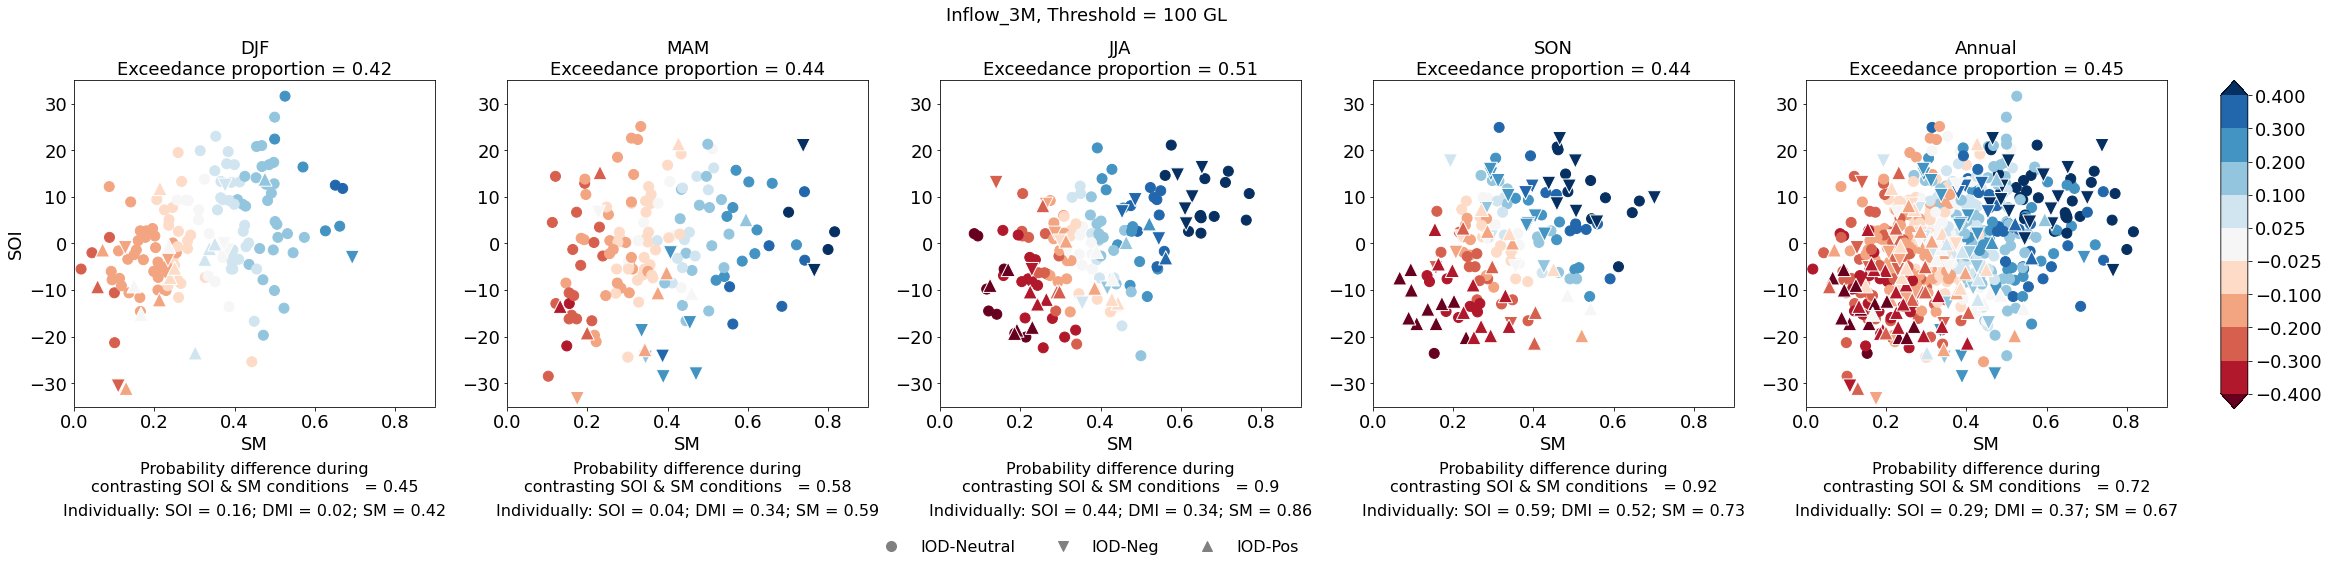

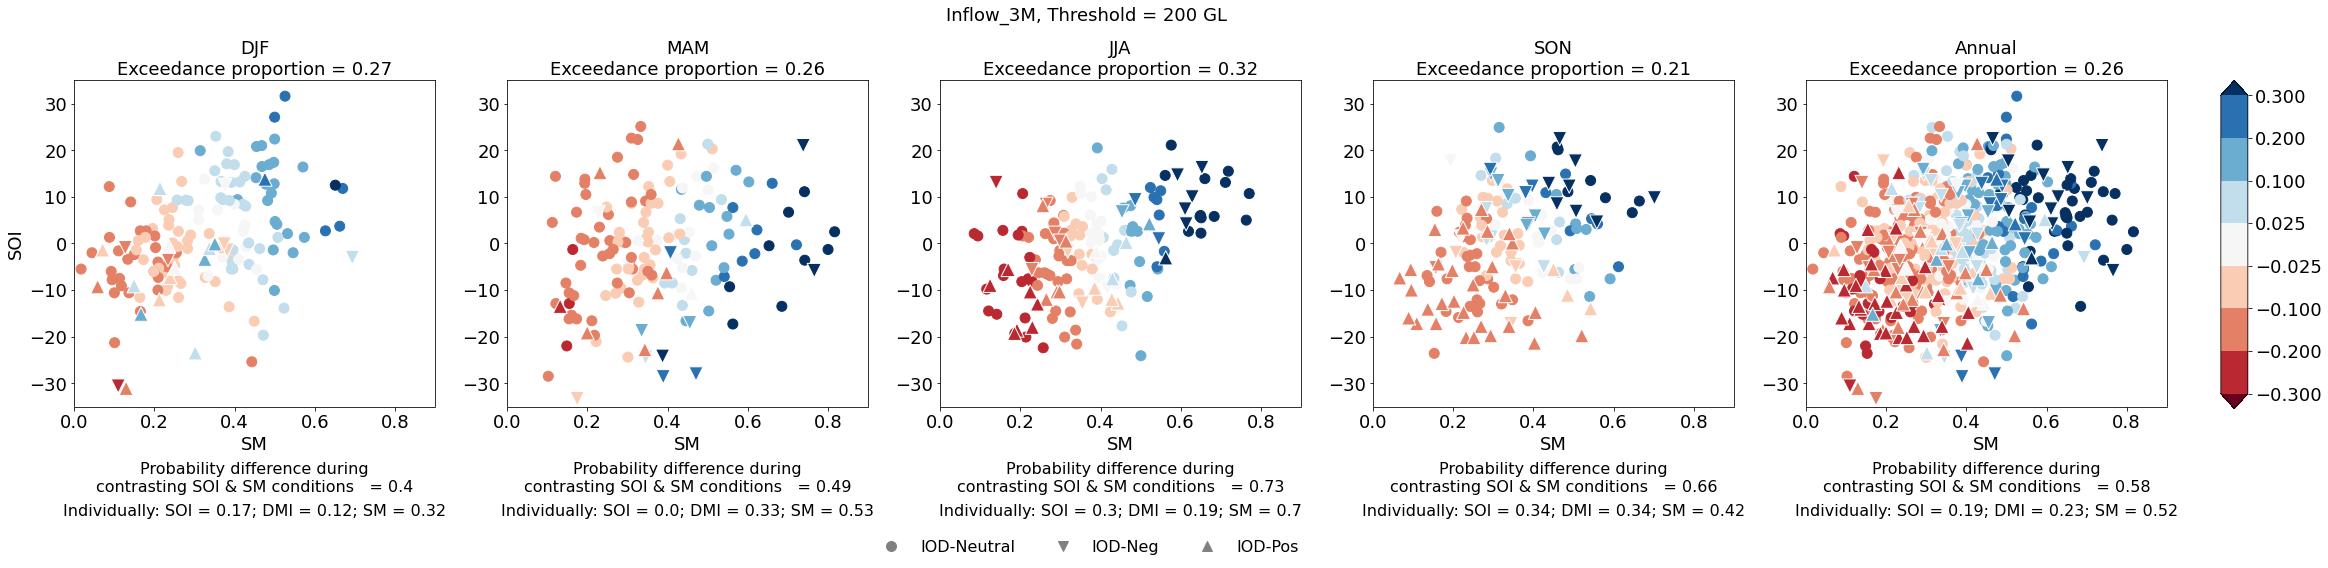

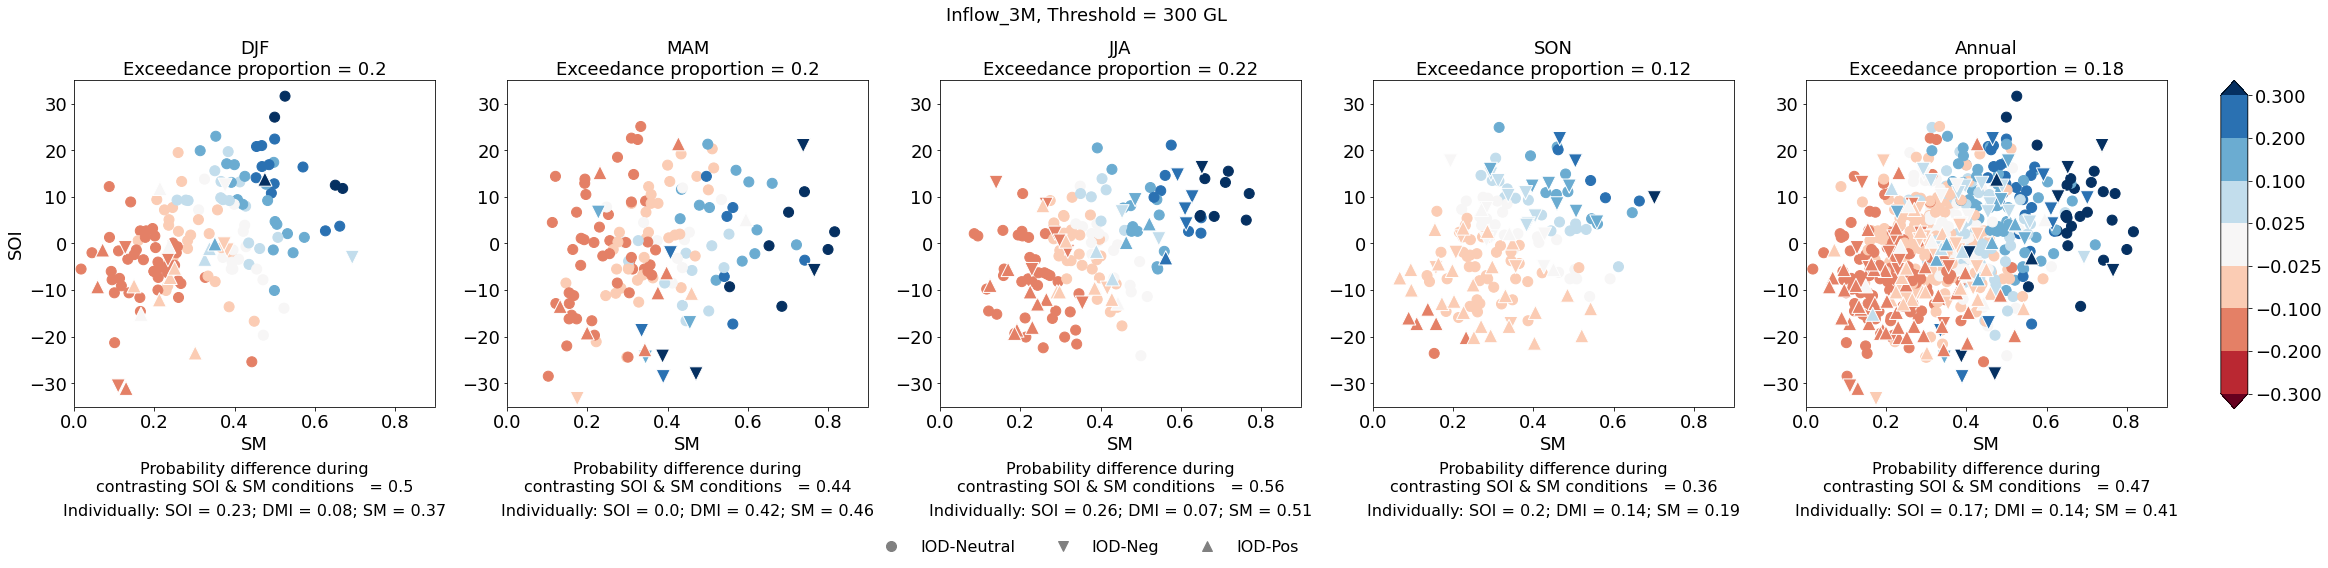

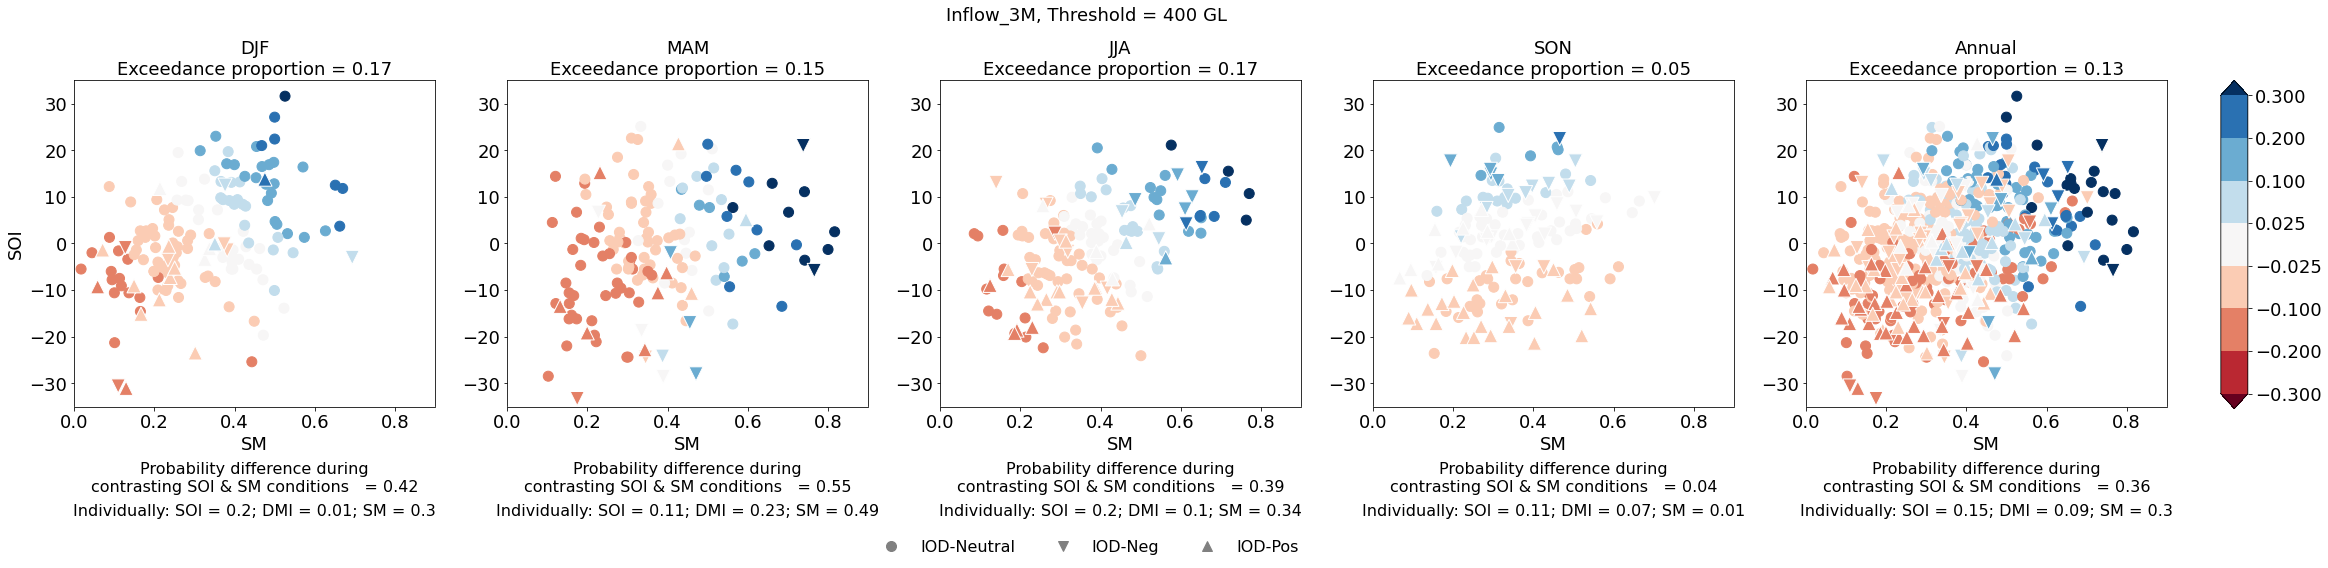

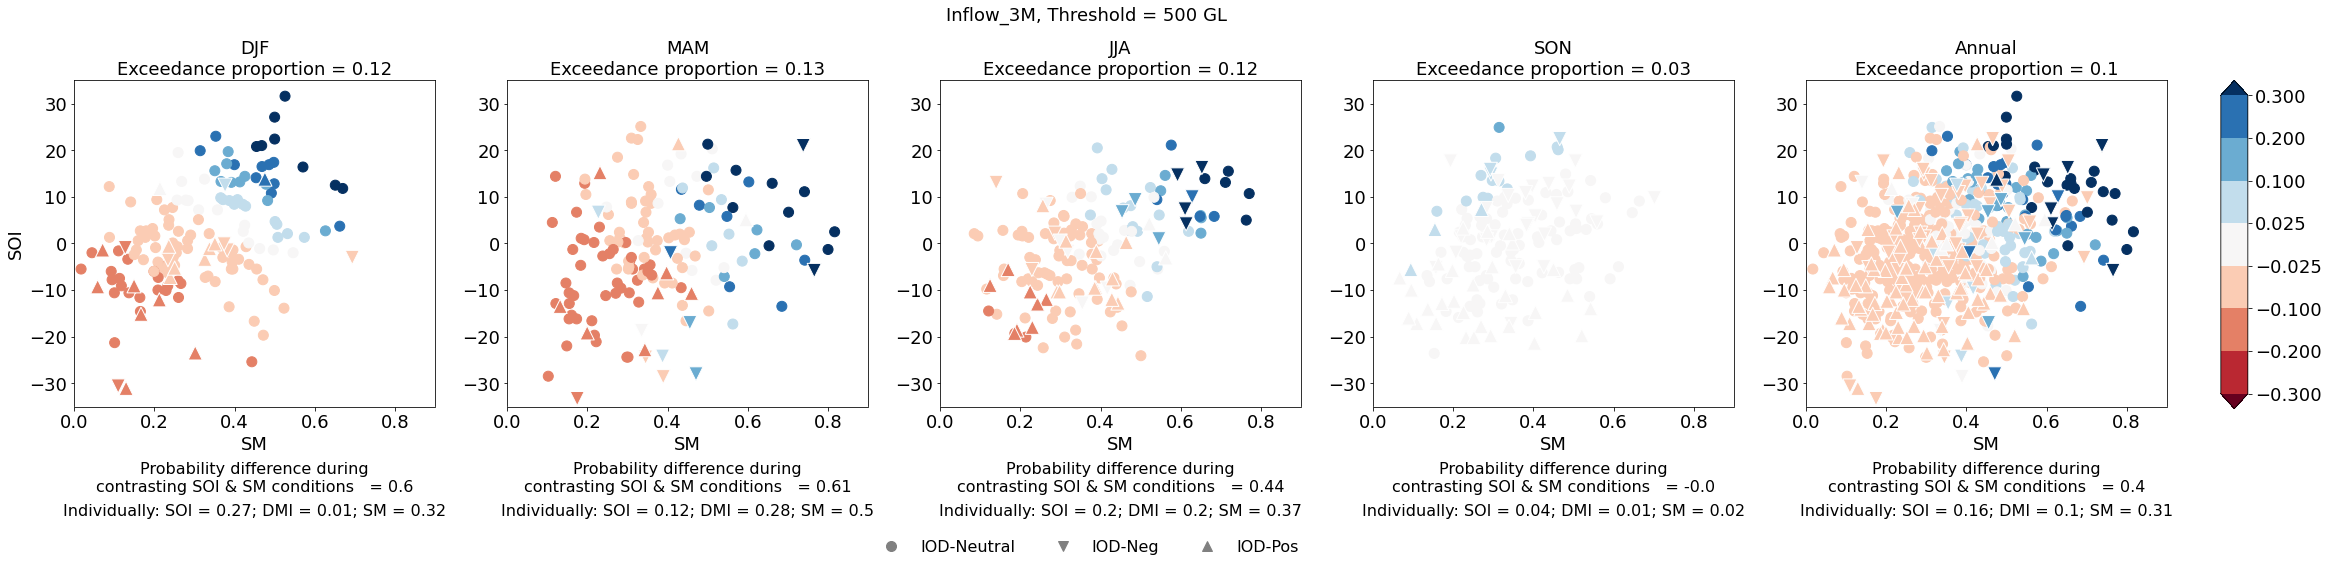

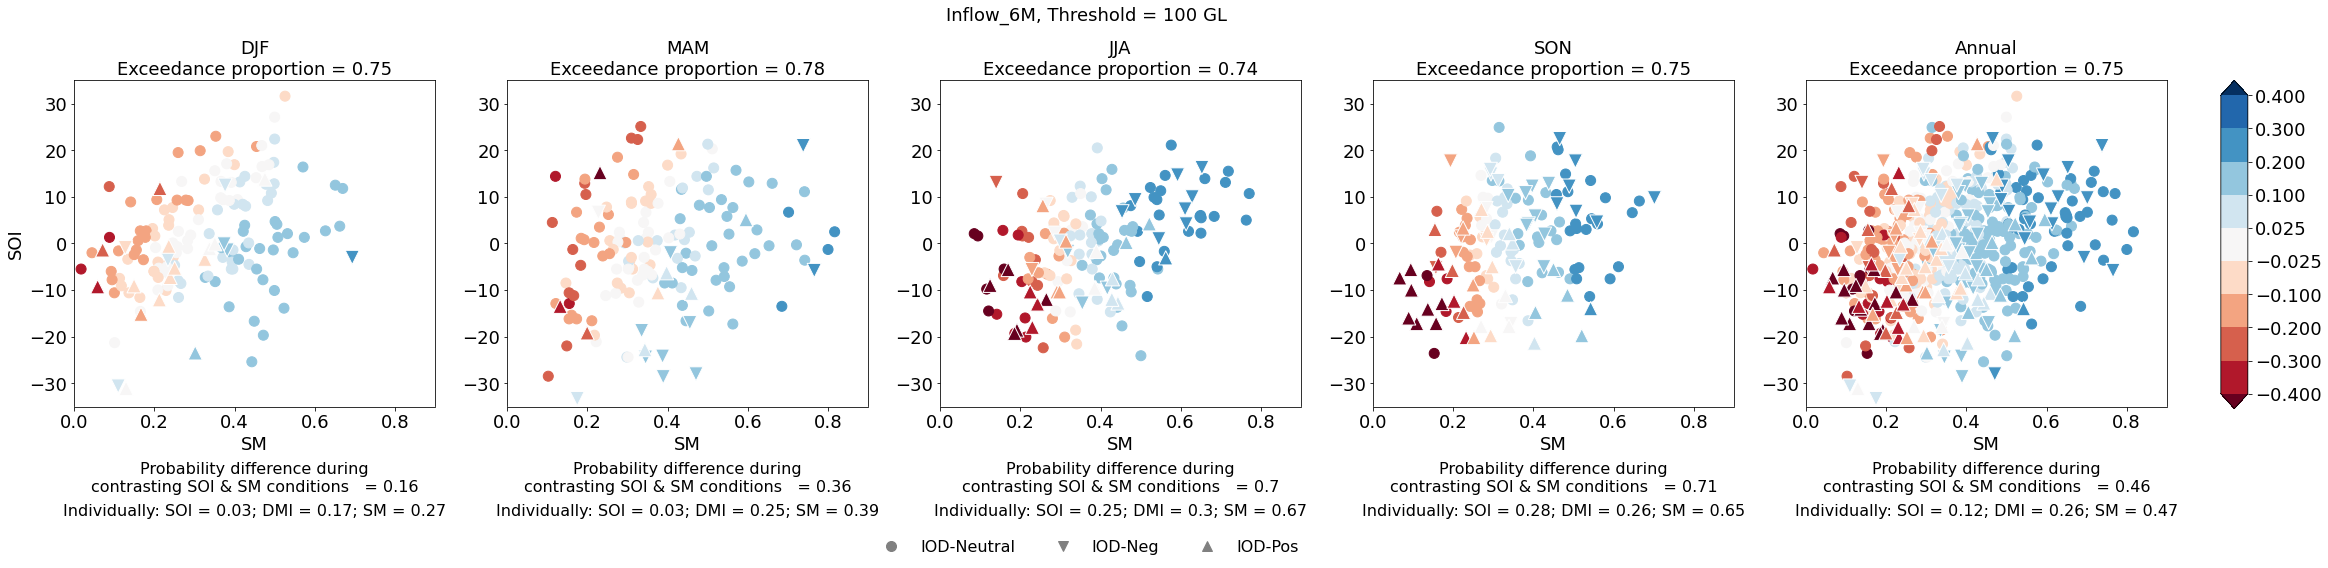

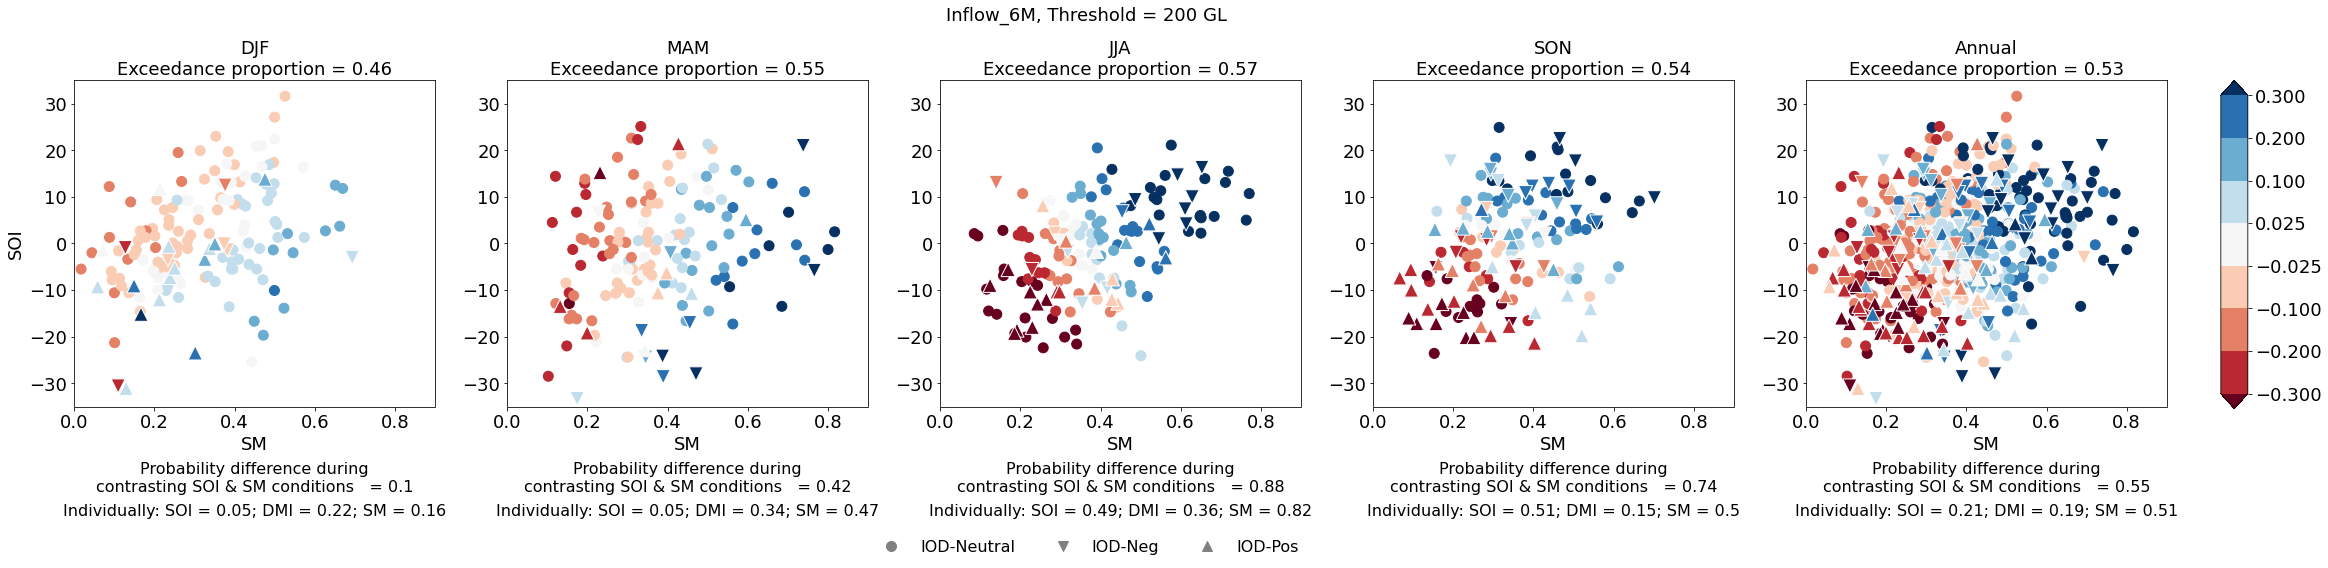

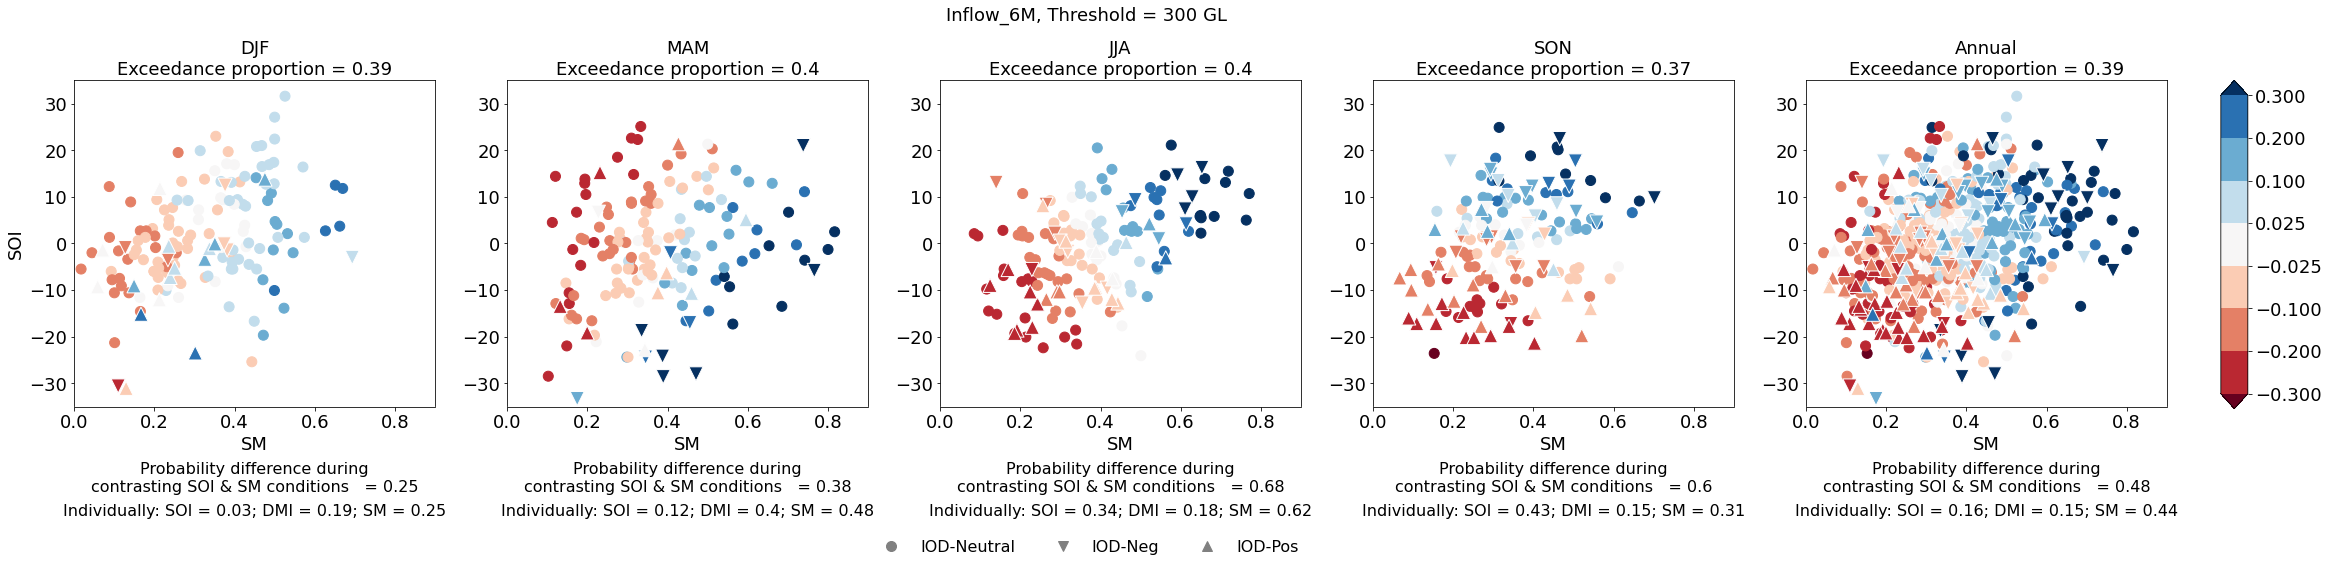

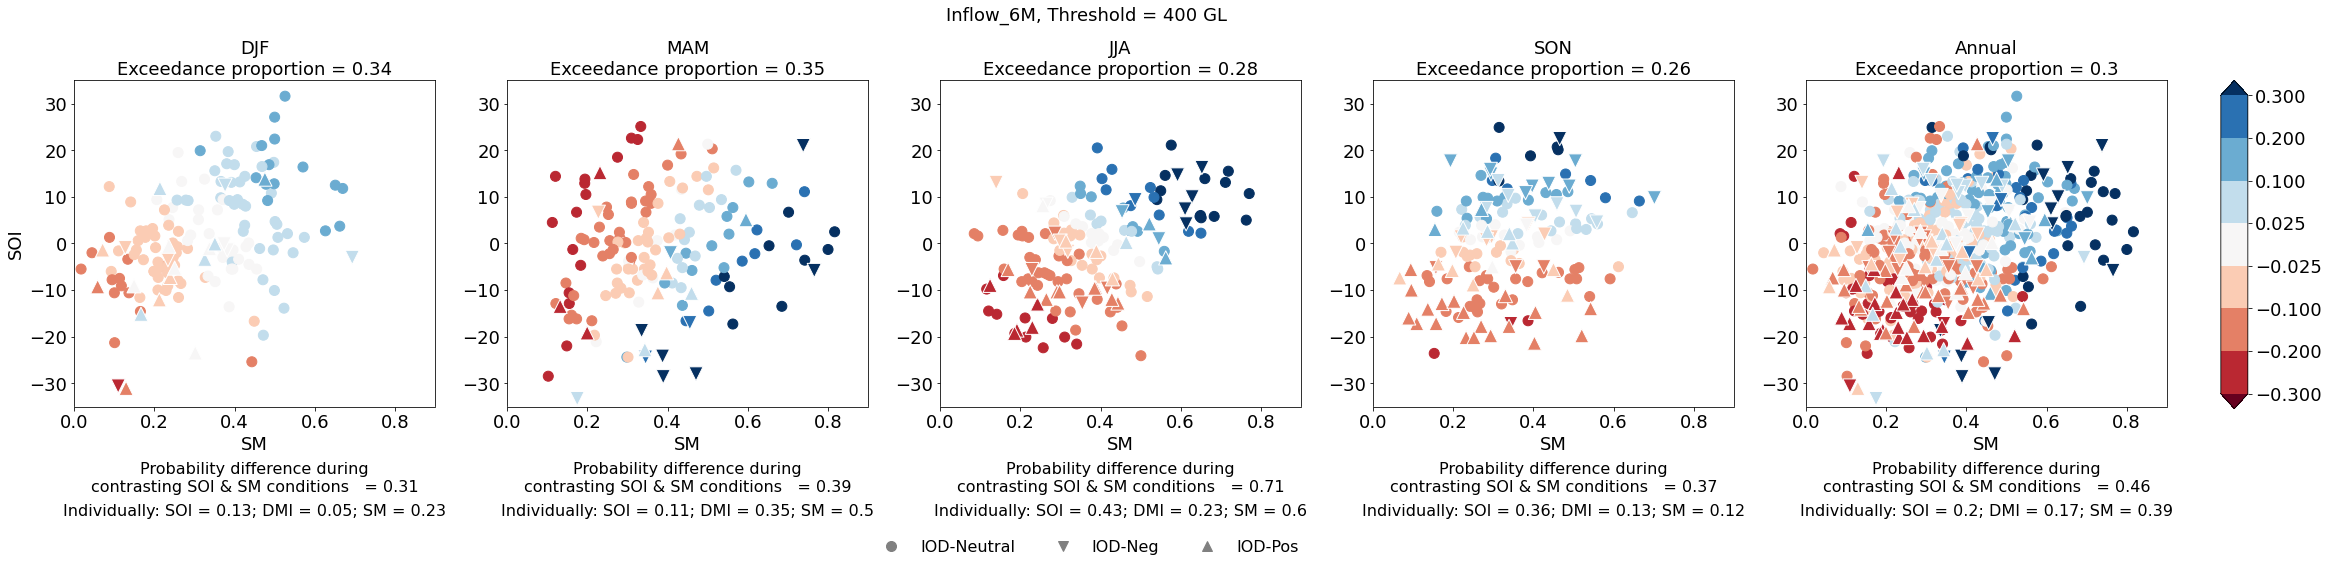

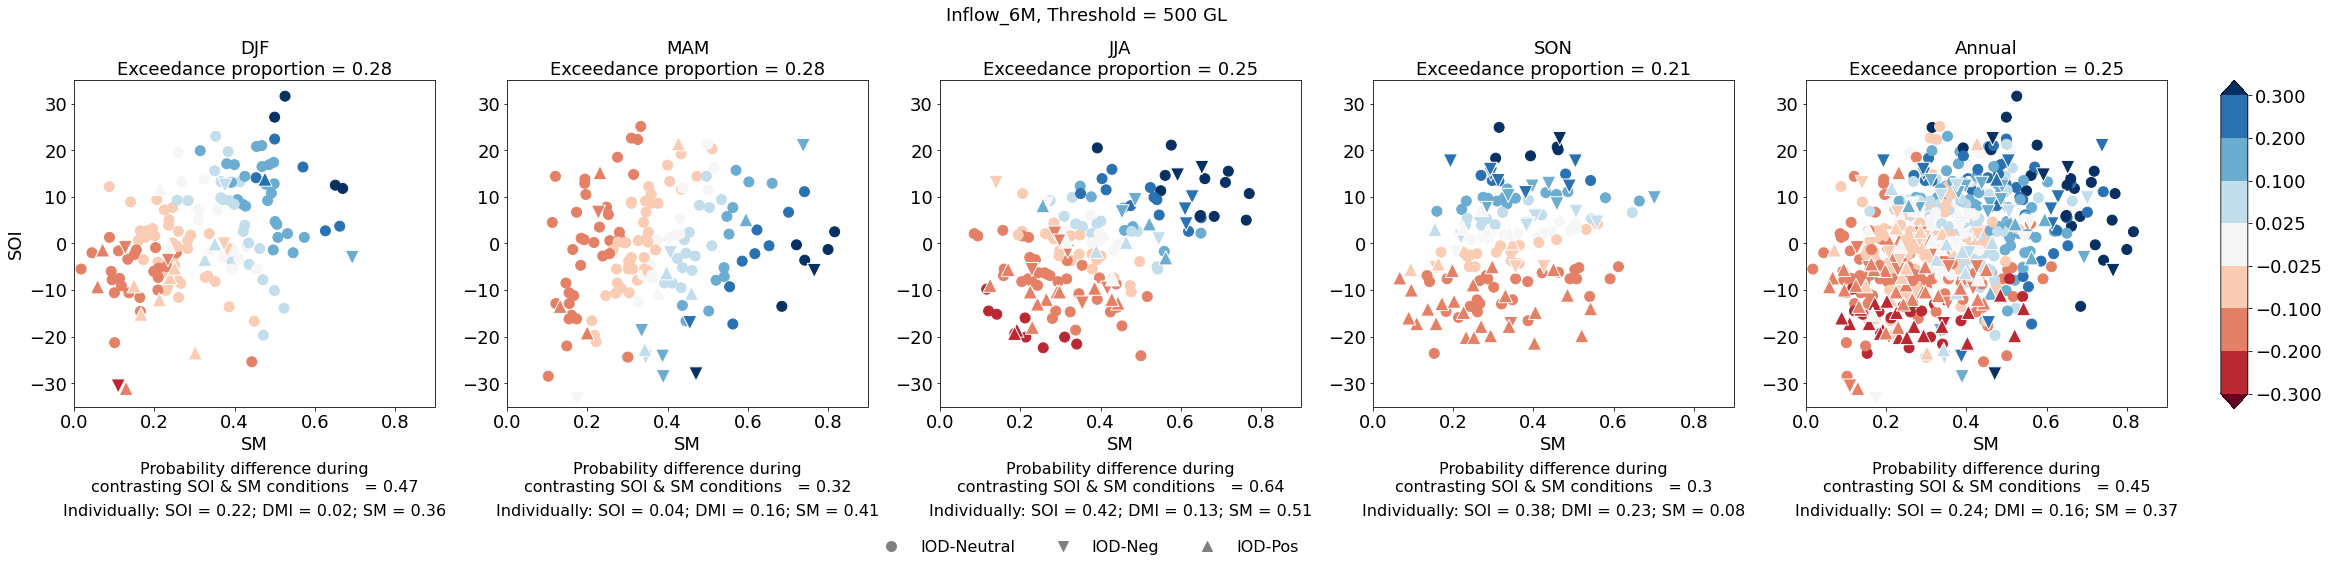

In [9]:
import matplotlib as mpl
from matplotlib.lines import Line2D

cmap = plt.cm.RdBu

bounds1 = [-0.4, -0.3, -0.2, -0.1, -0.025, 0.025, 0.1, 0.2, 0.3, 0.4]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap.N, extend='both')

bounds2 = [-0.3, -0.2, -0.1, -0.025, 0.025, 0.1, 0.2, 0.3]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap.N, extend='both')

# list of colorbar for each threshold
bounds_list = [bounds1, bounds2, bounds2, bounds2, bounds2]
norm_list = [norm1, norm2, norm2, norm2, norm2]

# settings for different IOD states
iod_state_list = ['Neutral', 'Neg', 'Pos']
marker_list = ['o', 'v', '^']
#edgecol_list = ['face', 'red', 'cyan']
edgecol_list = ['face', 'white', 'white']
size_list = [100, 200, 200]

soi_axis_lim = (-35, 35)
sm_axis_lim = (0, 0.9)

thresh_list = np.unique(fitted_contrib_values_lov['Inflow_3M']['seas_thresh_info']['threshold'].values)

seas_list = ['DJF', 'MAM', 'JJA', 'SON', 'Annual']

#******* should I change this? (maybe by season)
# sm_high = 0.7
# sm_low = 0.3
sm_high_dict = dict(zip(seas_list, perc90_list))
sm_low_dict = dict(zip(seas_list, perc10_list))

def add_scatter_plot(df_plot, norm, title, ax):
    for i, iod_state in zip(range(3), iod_state_list):
        cs = ax.scatter(df_plot['SM'][df_plot['IOD state'] == iod_state], df_plot['SOI'][df_plot['IOD state'] == iod_state], 
                               s = size_list[i], marker = marker_list[i], edgecolors = edgecol_list[i],
                               c = df_plot['probability'][df_plot['IOD state'] == iod_state],#.map(colors),
                               cmap = cmap, norm = norm_list[it])
    ax.set_title(title)
    return cs
        
def calc_extreme_pred_diff(df_plot, sm_high, sm_low):
    # the mean differences between opposite quadrants
    # df_high = df_plot[(df_plot['SM']>=sm_high) & (df_plot['SOI']>=8) & (df_plot['DMI']<=-0.4)]
    df_high = df_plot[(df_plot['SM']>=sm_high) & (df_plot['SOI']>=8)]
    p_high_mean = df_high['probability'].mean()
    #df_low = df_plot[(df_plot['SM']<=sm_low) & (df_plot['SOI']<=-8) & (df_plot['DMI']>=0.4)]
    df_low = df_plot[(df_plot['SM']<=sm_low) & (df_plot['SOI']<=-8)]
    p_low_mean = df_low['probability'].mean()
    p_diff = p_high_mean - p_low_mean
    return p_diff

def calc_extreme_singlePred_diff(df_plot, predName, high, low):
    # the mean differences between opposite quadrants
    df_high = df_plot[(df_plot[predName]>=high)]
    p_high_mean = df_high['probability'].mean()
    df_low = df_plot[(df_plot[predName]<=low)]
    p_low_mean = df_low['probability'].mean()
    p_diff = abs(p_high_mean - p_low_mean)
    return p_diff

for inflow_var in ['Inflow_3M', 'Inflow_6M']:
    fitted_prob_all = np.array(fitted_contrib_values_lov[inflow_var]['fittedValues'])
    for it, thresh in zip(range(len(thresh_list)), thresh_list):
        fig, ax = plt.subplots(nrows=1,ncols=5,figsize=(7.5*5,6))  #width, height
        #ax = ax.flatten() 
        count = 0
        for seas_sel in seas_list:
            sm_high = sm_high_dict[seas_sel]
            sm_low = sm_low_dict[seas_sel]
            if seas_sel == 'Annual':
                # indices of the model runs for the threshold
                ind_array = np.where(fitted_contrib_values_lov[inflow_var]['seas_thresh_info']['threshold'].values == thresh)[0]

                # calculating the observed proportion
                num_total = len(df_input[inflow_var])   #total number of obs in the season
                num_exceed = len(np.where(df_input[inflow_var] >= thresh)[0])  #the number of obs that exceeded thersh
                obs_prop = num_exceed/num_total

                # getting the fitted probability for that season & threshold
                fitted_prob_seas_thresh = fitted_prob_all[ind_array]
                dict_temp = {'SOI': df_input['SOI'],
                 'DMI': df_input['DMI'],
                 'SM': df_input['SM'],
                 'probability': fitted_prob_seas_thresh-obs_prop}
                df_plot = pd.DataFrame(dict_temp)
            else:
                # indices of the model runs for the threshold & season
                ind_array1 = np.where(fitted_contrib_values_lov[inflow_var]['seas_thresh_info']['threshold'].values == thresh)[0]
                ind_array2 = np.where(fitted_contrib_values_lov[inflow_var]['seas_thresh_info']['season'].values == seas_sel)[0]
                ind_array = np.intersect1d(ind_array1, ind_array2)

                # calculating the observed proportion estimate for that season & threshold
                num_total = len(df_input[df_input['season']==seas_sel][inflow_var])   #total number of obs in the season
                num_exceed = len(np.where(df_input[df_input['season']==seas_sel][inflow_var] >= thresh)[0])  #the number of obs that exceeded thersh
                obs_prop = num_exceed/num_total

                # getting the fitted probability for that season & threshold
                fitted_prob_seas_thresh = fitted_prob_all[ind_array]
                dict_temp = {'SOI': df_input[df_input['season']==seas_sel]['SOI'],
                 'DMI': df_input[df_input['season']==seas_sel]['DMI'],
                 'SM': df_input[df_input['season']==seas_sel]['SM'],
                 'probability': fitted_prob_seas_thresh-obs_prop}
                df_plot = pd.DataFrame(dict_temp)

            iod_state = np.repeat('Neutral', len(df_plot))
            iod_state[np.where(df_plot['DMI'].values >= 0.4)] = 'Pos'
            iod_state[np.where(df_plot['DMI'].values <= -0.4)] = 'Neg'
            df_plot['IOD state'] = iod_state
            
            title = seas_sel + '\nExceedance proportion = ' + str(np.round(obs_prop, 2))
            cs = add_scatter_plot(df_plot, norm = norm_list[it], title = title, ax = ax[count])
            
            # ax[count].text(0.06, 0.9, 'Exceedance\nProportion = ' + str(np.round(obs_prop, 2)), 
            #                ha='left', va='center', transform=ax[count].transAxes, fontsize=14, fontstyle='italic', color = 'black')
            
            p_diff = calc_extreme_pred_diff(df_plot, sm_high, sm_low)
            soi_diff = calc_extreme_singlePred_diff(df_plot, 'SOI', 8, -8)
            dmi_diff = calc_extreme_singlePred_diff(df_plot, 'DMI', 0.4, -0.4)
            sm_diff = calc_extreme_singlePred_diff(df_plot, 'SM', sm_high, sm_low)
            
            # if p_diff > 0.3:
            #     fontweight='bold'
            # else:
            #     fontweight='normal'
            fontweight = 'normal'
            ax[count].text(0.5, -0.22, 'Probability difference during\ncontrasting SOI & SM conditions   = ' + str(np.round(p_diff, 2)), 
                           ha='center', va='center', transform=ax[count].transAxes, fontweight=fontweight, fontsize=16, color = 'black')
            ax[count].text(0.5, -0.32, 'Individually: SOI = ' + str(np.round(soi_diff, 2)) + '; DMI = ' + str(np.round(dmi_diff, 2)) + '; SM = ' + str(np.round(sm_diff, 2)), 
                           ha='center', va='center', transform=ax[count].transAxes, fontweight=fontweight, fontsize=16, color = 'black')
            
            if count == 0:
                ax[count].set_ylabel('SOI')
            ax[count].set_xlabel('SM')
            ax[count].set_xlim(sm_axis_lim)
            ax[count].set_ylim(soi_axis_lim)
            count=count+1
            
        cbar_ax = fig.add_axes([0.92, 0.12, 0.01, 0.76])
        fig.colorbar(cs, cax=cbar_ax)
        legend_elements = []
        for i, iod_state in zip(range(3), iod_state_list):
                legend_elements.append(Line2D([0], [0], linewidth=0, marker=marker_list[i], color='grey', label='IOD-' + iod_state, markerfacecolor='grey', markersize=10))
                
        fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False)
        plt.suptitle(inflow_var + ', Threshold = ' + str(round(thresh/1000)) + ' GL', y = 1.05)
    
        fig.savefig(out_dir + inflow_var + 'thresh_' + str(thresh) + '_probability_diff_from_random.png', bbox_inches='tight', dpi = 600)
        fig.savefig(out_dir + inflow_var + 'thresh_' + str(thresh) + '_probability_diff_from_random.pdf', bbox_inches='tight', format = 'pdf')

### Probabilities predicted during the recent historical period

In [10]:
# code to create datasets containing model probability

nTime = len(ds['time'])
dict_temp = {"season": ds['time.season'].values[1:nTime], 
             "time": ds['time'].values[1:nTime],
             "Inflow_3M": ds['Inflow_3M'][1:nTime], 
             "Inflow_6M": ds['Inflow_6M'][1:nTime], 
             "SOI":ds['soi'].values[0:nTime-1], 
             "DMI":ds['dmi'].values[0:nTime-1], 
             "SM":da_sm.values[1:nTime]}

df_input = pd.DataFrame(dict_temp)

thresh_list = [100000, 200000, 300000, 400000, 500000]
accum_months = [3, 6]

list_ds1_insamp = []
list_ds1 = []

for inflow_var in ['Inflow_3M', 'Inflow_6M']:
    list_ds2_insamp = []
    list_ds2 = []
    for it, thresh in zip(range(len(thresh_list)), thresh_list):
            
        #*****************
        # LOV
        #*****************
        ind_array1 = np.where(fitted_contrib_values_lov[inflow_var]['seas_thresh_info']['threshold'].values == thresh)[0]
        prob_lov_all = np.array(fitted_contrib_values_lov[inflow_var]['fittedValues'])
        prob_lov = prob_lov_all[ind_array1]
        time_lov = df_input['time']
        
        dict_temp = {'time': time_lov, 'probability': prob_lov}
        df_mdl_prob = pd.DataFrame(dict_temp)
        ds_mdl_prob_thresh = df_mdl_prob.to_xarray()
        ds_mdl_prob_thresh = ds_mdl_prob_thresh.set_index(index="time").rename({'index':'time'})
        list_ds2.append(ds_mdl_prob_thresh)
    
    ds_thresh_concat = xr.concat(list_ds2, dim = 'threshold').assign_coords({'threshold': thresh_list})
    list_ds1.append(ds_thresh_concat)
    
ds_mdl_prob = xr.concat(list_ds1, dim = 'accum_months').assign_coords({'accum_months':accum_months})

In [11]:
# Storage and spill data used to identify historical extreme periods
# Data source: https://www.righttoknow.org.au/request/inflow_levels_rainfall_outflow_l
data_dir = '/g/data/w97/ad9701/warragamba_project/'

storage_file = 'dam_storage_1970_2017.csv'
spill_file = 'dam_spill_1995_2017.csv'

df_storage = pd.read_csv(data_dir + storage_file)
col_rename_dict = dict(zip(df_storage.keys().values, ['Date', 'Storage Vol', 'Storage Level'])) 
df_storage = df_storage.rename(columns = col_rename_dict)
#print(df_storage.head())

array_datetime1 = np.array([datetime.strptime(x, "%d/%m/%y") for x in df_storage['Date']])
array_time1 = pd.to_datetime(array_datetime1).to_numpy().astype('datetime64[D]')

df_storage['time'] = array_time1
df_storage = df_storage.set_index('time')
#print(df_storage.head())
ds_storage = df_storage.to_xarray()

df_spill_all = pd.read_csv(data_dir + spill_file)
df_spill = df_spill_all[['   Date   ', 'Spill at Warragamba Dam (col33)']]
col_rename_dict = dict(zip(['   Date   ', 'Spill at Warragamba Dam (col33)'],
                           ['Date', 'Spill']))
df_spill = df_spill.rename(columns = col_rename_dict)

array_datetime2 = np.array([datetime.strptime(x, "%d/%m/%Y %H:%M") for x in df_spill['Date']])
array_time2 = pd.to_datetime(array_datetime2).to_numpy().astype('datetime64[D]')
                       
df_spill['time'] = array_time2
df_spill = df_spill.set_index('time')                                                    
ds_spill = df_spill.to_xarray()

df_input = df_input.set_index('time')                                                    
ds_input = df_input.to_xarray()

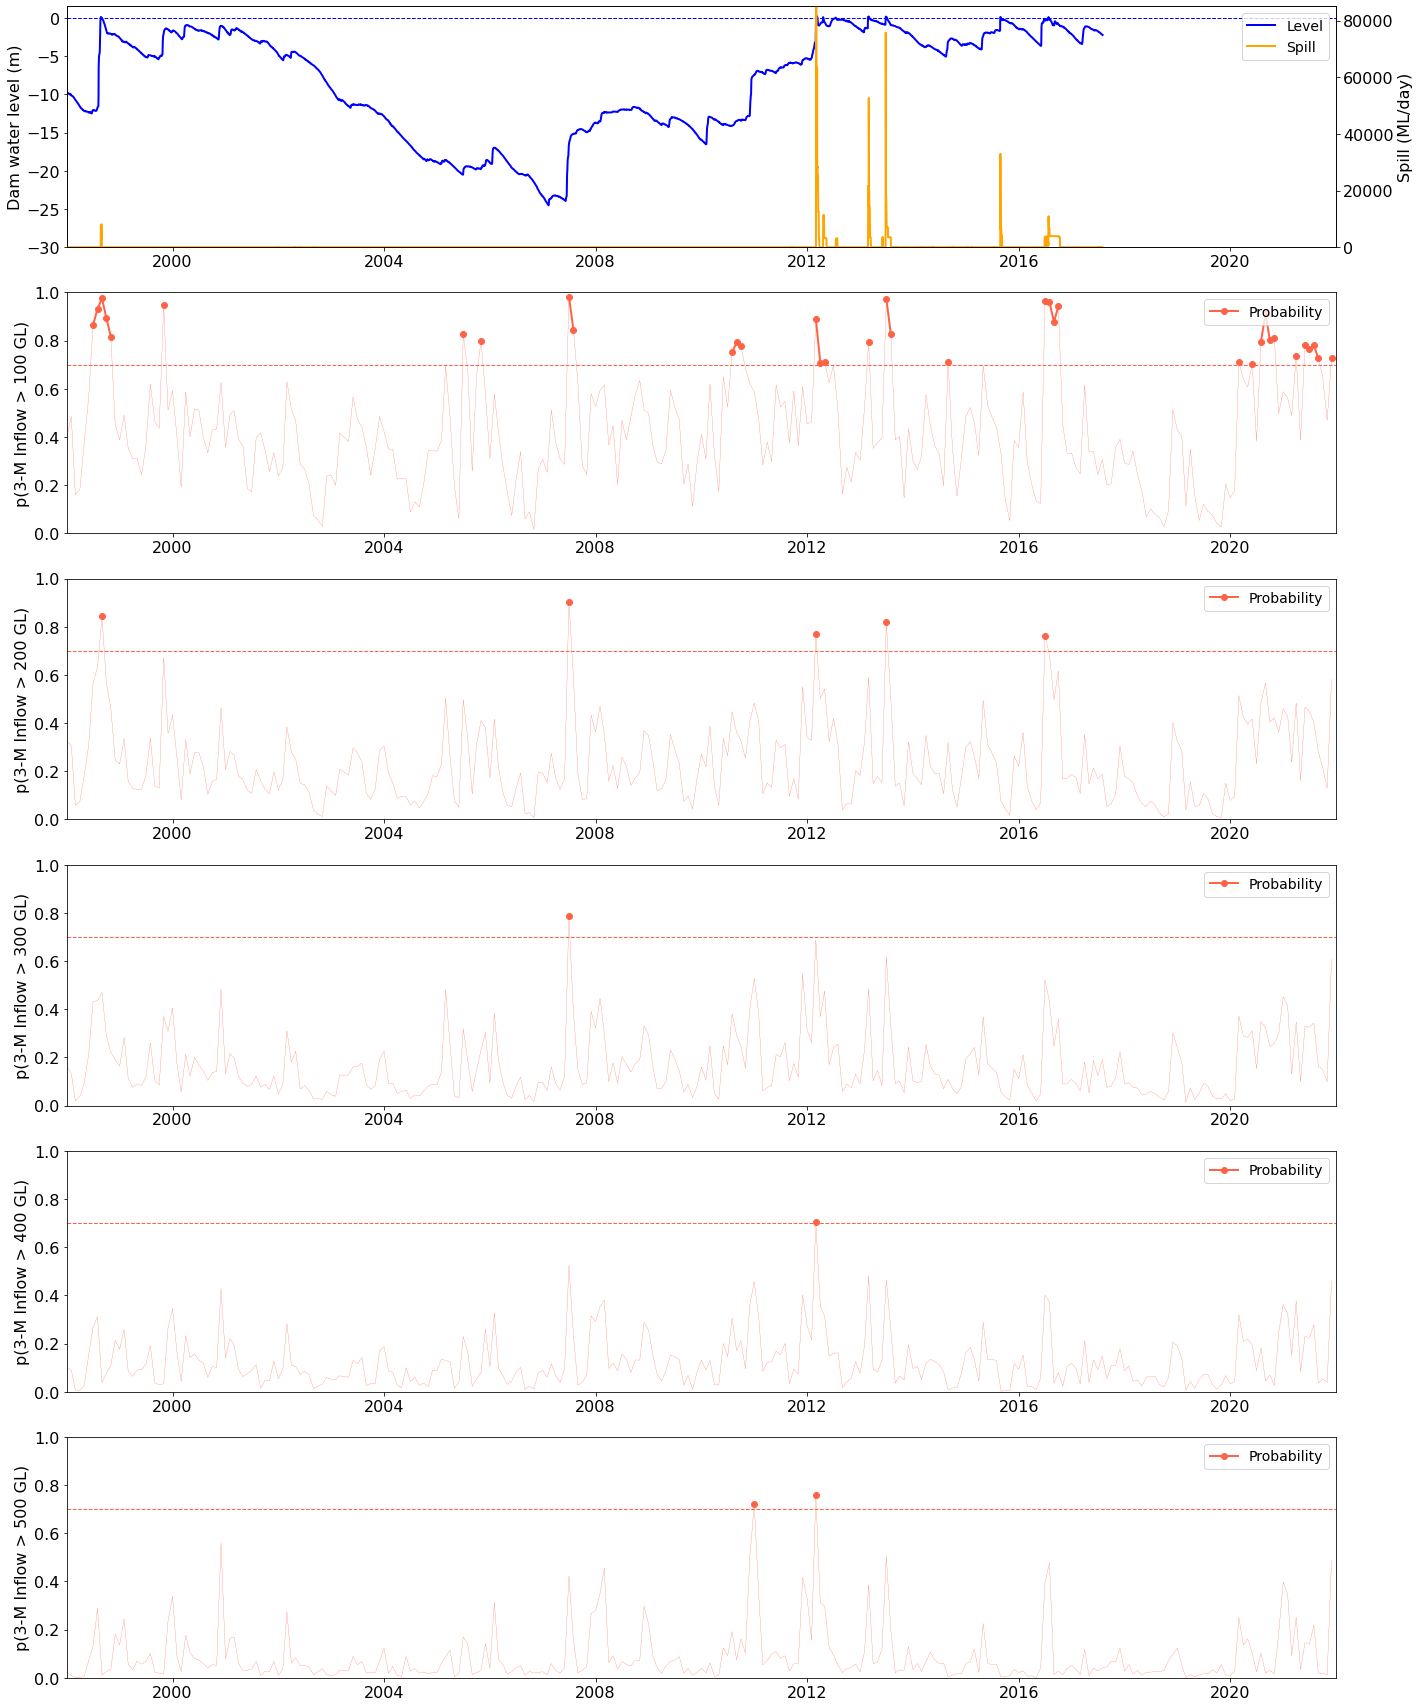

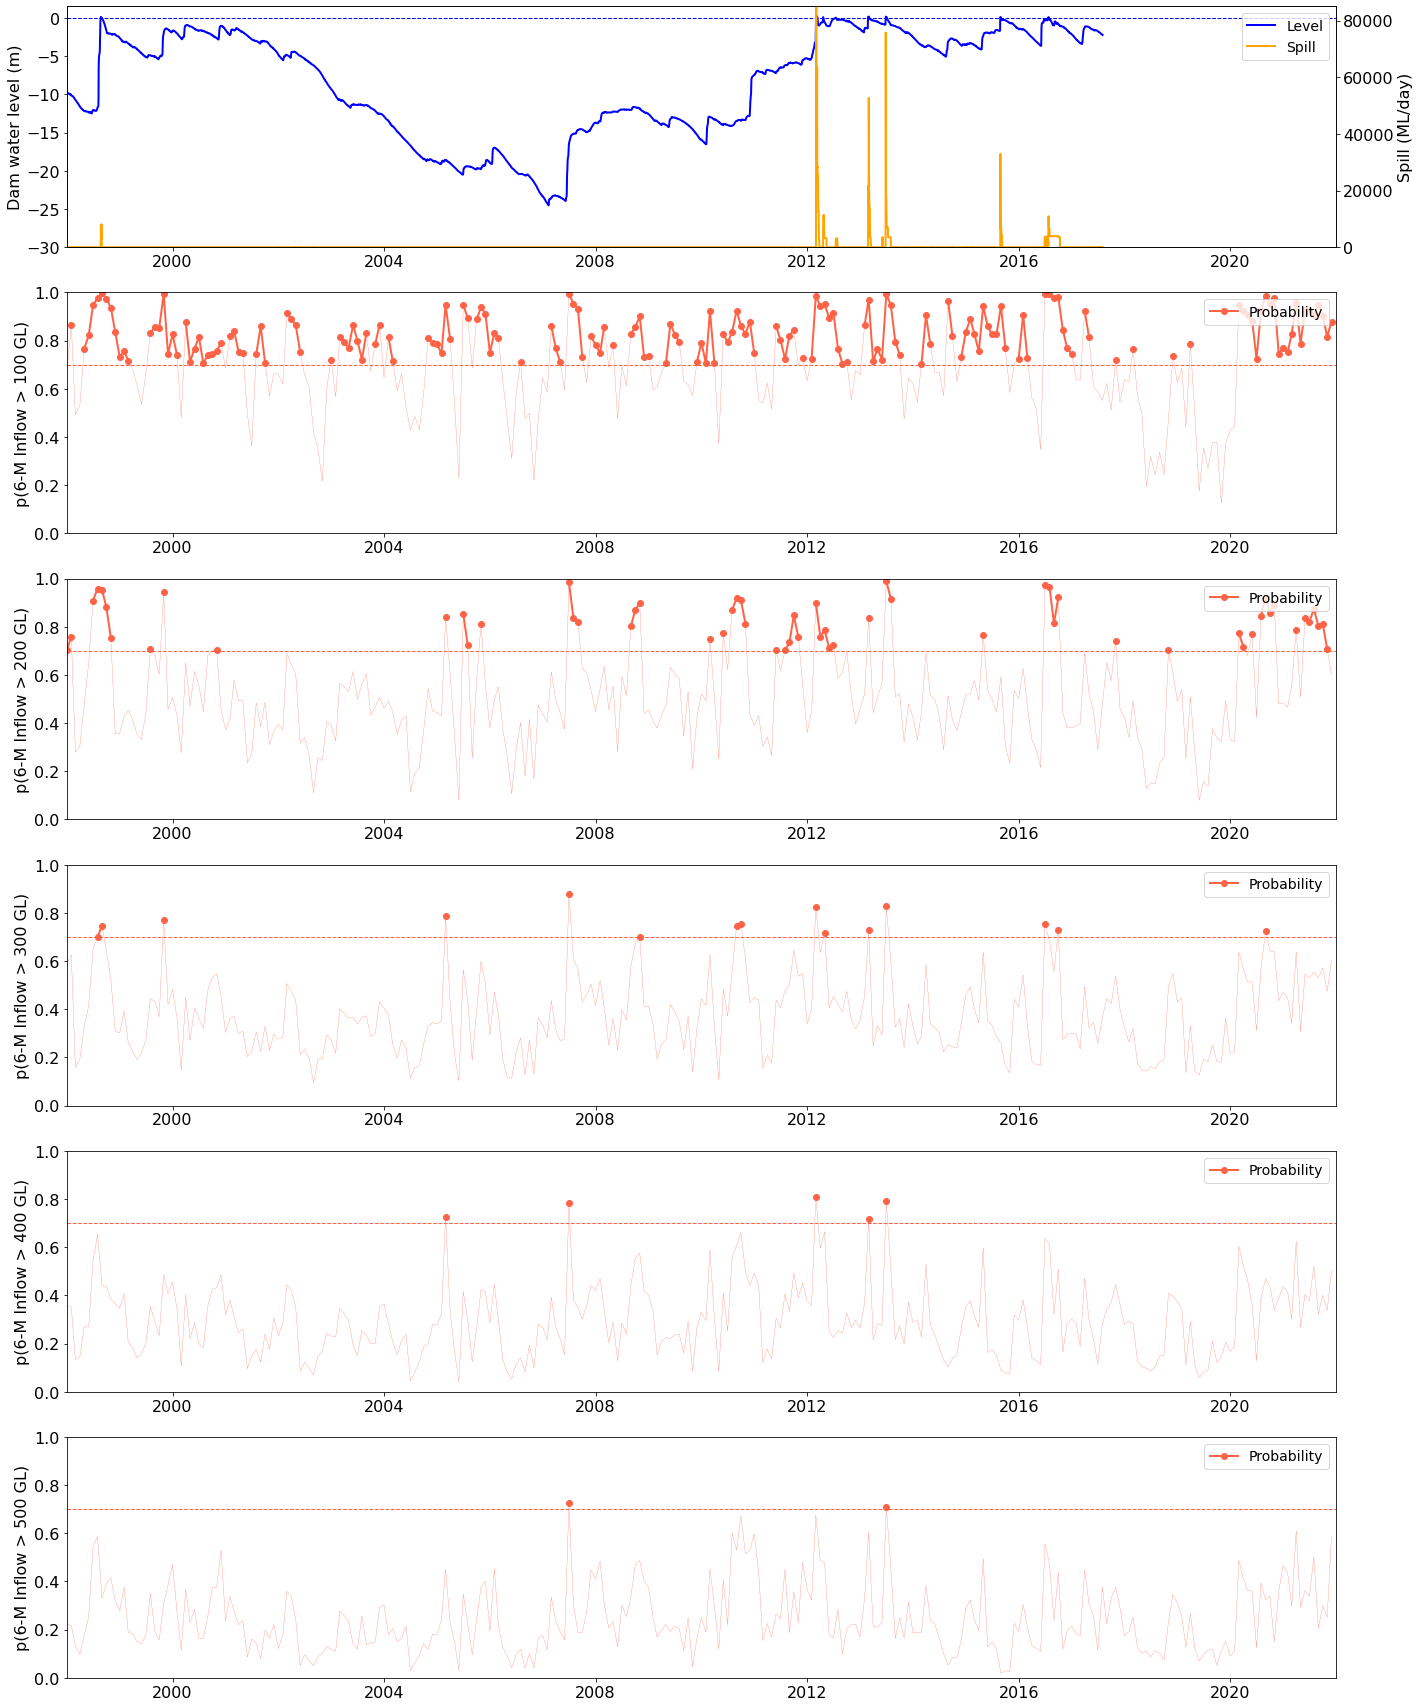

In [12]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def to_np_date(x):
    x_dt = datetime.strptime(x, '%Y-%m-%d')
    x_np_date = pd.to_datetime(x_dt).to_numpy().astype('datetime64[D]')
    return(x_np_date)

for accum_months in [3, 6]:
    
    inflow_var = 'Inflow_' + str(accum_months) + 'M'

    list_time = [slice('1998','2021')] #, slice('2014', '2019')]
    xlim_list = [(to_np_date('1998-01-01'), to_np_date('2022-01-01'))] #, 
                 #(to_np_date('2014-01-01'), to_np_date('2020-01-01'))]
    list_figName = ['prob_n_inflow_1998to2021'] #, 'prob_n_inflow_wet_2014to2019']

    col1 = 'blue'
    lwd1 = 2
    #ylim1 = (0, 2.1e6)
    ylim1 = (-30, 1.5)
    #ylab1 = 'Dam Storage (ML)'
    ylab1 = 'Dam water level (m)'
    llab1 = 'Level'
    lty1 = '-'

    col2 = 'orange'
    lwd2 = 2
    ylim2 = (0, 85000)
    ylab2 = 'Spill (ML/day)'
    llab2 = 'Spill'
    lty2 = '-'

    col3 = 'black'
    lwd3 = 2
    ylim3 = (0, 990000)
    ylab3 = 'Subsequent ' + str(accum_months) + '-month Inflow'
    llab3 = 'Inflow'
    lty3 = '-'

    cmap = matplotlib.cm.get_cmap('YlOrRd')
    prob_cols = cmap(np.linspace(0.2, 1, len(thresh_list)))

    thresh_list = ds_mdl_prob.threshold.values
    col4 = 'tomato' #prob_cols[0]
    lwd4 = 2
    ylim4 = (0, 1)
    lty4 = '-'

    col_list = [col1, col2]
    lwd_list = [lwd1, lwd2]
    ylim_list = [ylim1, ylim2]
    ylab_list = [ylab1, ylab2]
    lty_list = [lty1, lty2]
    llab_list = [llab1, llab2]


    for i, time_sel in zip(range(len(list_time)), list_time):

        nrows = 1 + len(thresh_list)
        fig, axs = plt.subplots(nrows = nrows, ncols = 1, figsize=(20,4*nrows), tight_layout=True)

        ###########
        # Panel 1
        ###########
        axs2 = axs[0].twinx()
        ax_list = [axs[0], axs2]

        da_plt1 = ds_storage['Storage Level'].sel(time = time_sel)
        da_plt2 = ds_spill['Spill'].sel(time = time_sel)
        da_list = [da_plt1, da_plt2]

        lns_list = []
        for ax, da_plt, col, lwd, ylim, ylab, lty, llab in zip(ax_list, da_list, col_list, lwd_list, ylim_list, ylab_list, lty_list, llab_list):
            lns_temp = ax.plot(da_plt.time.values, da_plt.values, color = col, linewidth = lwd, linestyle = lty, label = llab)
            lns_list.append(lns_temp)
            ax.set_ylim(ylim)
            ax.set_ylabel(ylab)
        axs[0].axhline(y = 0, color = col_list[0], linewidth = 1, linestyle = '--')

        # added two lines in legend
        lns = lns_list[0]+lns_list[1]
        labs = [l.get_label() for l in lns]
        axs[0].legend(lns, labs, loc=1)
        
        axs[0].set_xlim(xlim_list[i])
        axs2.set_xlim(xlim_list[i])

        ########################
        # The following panels
        ########################

        for ithresh in range(len(list(thresh_list))):
            
            # axs3 = axs[1+ithresh].twinx()
            # da_plt3 = ds_input[inflow_var].sel(time = time_sel)
            # #### exclude DJF
            # #da_plt3 = da_plt3.where(~np.isin(da_plt3['time.season'].values, ['DJF']))
            # lns3 = axs3.plot(da_plt3.time.values, da_plt3.values, color = col3, linewidth = 0.75, linestyle = lty3, label = llab3)
            # da_plt3 = da_plt3.where(da_plt3 >= thresh_list[ithresh])
            # lns3 = axs3.plot(da_plt3.time.values, da_plt3.values, color = col3, linewidth = lwd3, linestyle = lty3, label = llab3, marker='o')
            # axs3.set_ylim(ylim3)
            # axs3.set_ylabel(ylab3)

            da_plt4 = ds_mdl_prob['probability'].sel(accum_months = accum_months, time = time_sel).isel(threshold = ithresh)
            #### exclude DJF
            #da_plt4 = da_plt4.where(~np.isin(da_plt4['time.season'].values, ['DJF']))
            lns4 = axs[1+ithresh].plot(da_plt4.time.values, da_plt4.values, color = col4, linewidth = 0.25, linestyle = lty4, label = 'Probability')#, marker='o')
            #lns4_insamp = axs[1+ithresh].plot(da_plt4_insamp.time.values, da_plt4_insamp.values, color = 'green', linewidth = 1, linestyle = ':', label = 'In-Sample Probability')#, marker='o')
            da_plt4 = da_plt4.where(da_plt4 >= 0.7)
            lns4 = axs[1+ithresh].plot(da_plt4.time.values, da_plt4.values, color = col4, linewidth = lwd4, linestyle = lty4, label = 'Probability', marker='o')
            #ylab4 = 'p(' + str(accum_months) + '-M Inflow > ' + format(thresh_list[ithresh], ',') + ')'
            ylab4 = 'p(' + str(accum_months) + '-M Inflow > ' + str(round(thresh_list[ithresh]/1000)) + ' GL)'
            axs[1+ithresh].set_ylim(ylim4)
            axs[1+ithresh].set_ylabel(ylab4)

            # axs3.axhline(y = thresh_list[ithresh], color = col3, linewidth = 1, linestyle = '--')
            #axs[1+ithresh].axhline(y = 0.5, color = 'lightsalmon', linewidth = 1, linestyle = '--')
            axs[1+ithresh].axhline(y = 0.7, color = col4, linewidth = 1, linestyle = '--')

            # added two lines in legend
            # lns = lns3 + lns4 #+ lns4_insamp
            lns = lns4
            labs = [l.get_label() for l in lns]
            axs[1+ithresh].legend(lns, labs, loc=1)
            
            # axs3.set_xlim(xlim_list[i])
            axs[1+ithresh].set_xlim(xlim_list[i])

        fig.savefig(out_dir + inflow_var + list_figName[i] + '.png', bbox_inches='tight', dpi = 600)
        fig.savefig(out_dir + inflow_var + list_figName[i] + '.pdf', bbox_inches='tight', format = 'pdf')

### Subset data points when high probability is predicted & write information to CSV files

In [13]:
da_spill_mon = ds_spill['Spill'].resample(time="M").sum()
time_array_mon = da_spill_mon.time.values.astype('datetime64[M]')
da_spill_mon = da_spill_mon.assign_coords({'time': time_array_mon})

# calculate & save the next few-month cumulative inflows
da_spill_3mon = da_spill_mon.rolling(time=3, center=False).sum().shift(time=-2)
da_spill_6mon = da_spill_mon.rolling(time=6, center=False).sum().shift(time=-5)

In [14]:
prob_thresh = 0.7

accum_months_list = [3, 6]
time_sel = slice('1970', '2021')
thresh_sel_dict = {3: [100000, 200000],
                   6: [300000, 400000]}
spill_accum_dict = {3: da_spill_3mon,
                    6: da_spill_6mon}
inflow_dict = {3: ds['Inflow_3M'],
           6: ds['Inflow_6M']}

for accum_months in accum_months_list:
    
    thresh_sel_list = thresh_sel_dict[accum_months]
    da_spill_accum = spill_accum_dict[accum_months]
    da_inflow_accum = inflow_dict[accum_months]
    
    for thresh_sel in thresh_sel_list:
        
        # get the estimated probability for the selected accum & threshold
        da_p_accumMon = ds_mdl_prob['probability'].sel(accum_months = accum_months, time = time_sel, threshold = thresh_sel)
        da_highP_date = da_p_accumMon.time.where(da_p_accumMon >= prob_thresh)  # select the values above prob. threshold

        # the months that show highP
        time_highP = np.unique(da_highP_date.values)
        temp = len(time_highP)
        time_highP = time_highP[0:(temp-1)]  # get rid of the last value which would be NanT
        da_highP = da_p_accumMon.sel(time = time_highP)

        # print('----------------------------------------------------------------')
        # print('threshold = ' + str(thresh_sel))

        # I have dam storage & level data between 1995-2017; subsetting accordingly
        time_highP_subset = time_highP[(time_highP < np.datetime64('2017-02-15')) & (time_highP > np.datetime64('1995-06-15'))] 
        nan_array1 = np.array([np.nan]*sum(time_highP >= np.datetime64('2017-02-15'))) # setting the rest of the dates to nan
        nan_array2 = np.array([np.nan]*sum(time_highP <= np.datetime64('1995-06-15')))
        temp_spill = da_spill_accum.sel(time = time_highP_subset).values
        temp_spill = np.append(nan_array2, temp_spill)
        temp_spill = np.append(temp_spill, nan_array1)

        # dam level data only till 2017
        time_highP_subset = time_highP[time_highP < np.datetime64('2017-02-15')]
        temp_level = ds_storage['Storage Level'].sel(time = time_highP_subset).values
        temp_level = np.append(temp_level, nan_array1)
        
        # subsequent inflow
        temp_inflow = da_inflow_accum.sel(time = time_highP).values
        
        temp_dict = {'date': time_highP, 
                     'probability': da_highP.values,
                     'next ' + str(accum_months) + '-mon inflow': temp_inflow, 
                     'next ' + str(accum_months) + '-mon spill': temp_spill, 
                     'dam level': temp_level}
        
        out_file = out_dir + 'dataPts_exceed_prob' + str(prob_thresh) + '_accum_' + str(accum_months) + 'mon_' + 'inflowThresh_' + str(round(thresh_sel/1000)) + 'GL.csv'
        temp_df = pd.DataFrame(temp_dict)
        temp_df.to_csv(out_file)

### Reliability diagrams for validation

In [15]:
def calc_obs_prop(model_array, obs_array, model_min, model_max):
    # get the index of values that fall in the model bin
    model_bin = np.where((model_array <= model_max) & (model_prob > model_min))[0]
    if len(model_bin) > 0:
        obs_prop = np.sum(obs_array[model_bin])/len(model_bin)
        model_median = np.median(model_array[model_bin])
    else:
        obs_prop = np.nan
        model_median = np.nan
    return obs_prop, model_median, len(model_bin)

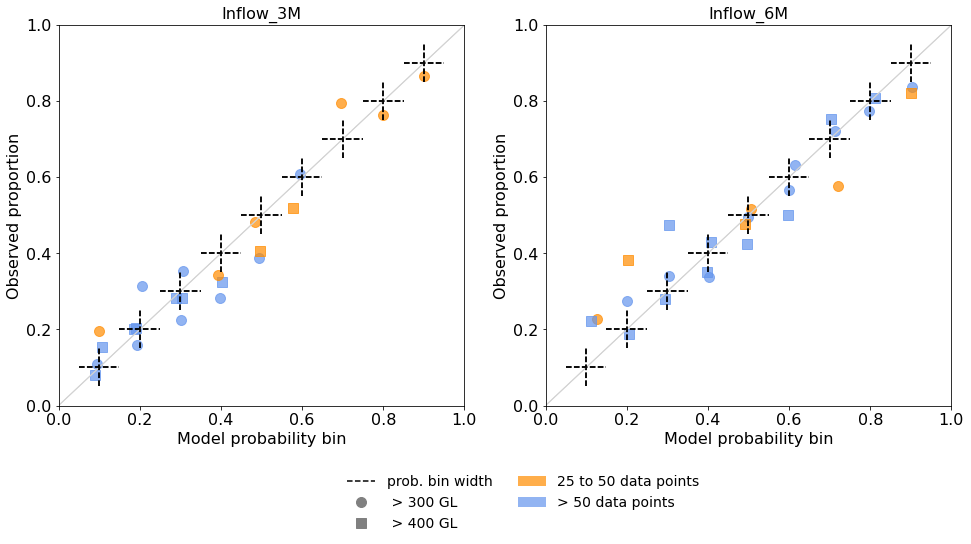

In [17]:
bin_min = np.linspace(0.05, 0.85, 9)
bin_max = np.linspace(0.15, 0.95, 9)
bin_centre = np.linspace(0.1, 0.9, 9)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8*2, 7)) #width, height
ax = ax.flatten()

col1 = 'darkorange'
col2 = 'cornflowerblue'

axlim = (0, 1)

marker_list = ['o', 's', ]

thresh_list_allfig = [[100000, 200000], [300000, 400000]]
figname_list = ['Inflow_scatterPlot_outofSample_validation_fig' + str(i) for i in range(1,len(thresh_list_allfig)+1)]

for figname, thresh_list in zip(figname_list, thresh_list_allfig):

    count_accum=0
    for inflowAccum in ['Inflow_3M', 'Inflow_6M']:
        seas_thresh_info = fitted_contrib_values_lov[inflowAccum]['seas_thresh_info']
        model_prob_all = np.array(fitted_contrib_values_lov[inflowAccum]['fittedValues'])

        count = 0
        for thresh_sel in thresh_list:
            y = np.where(ds[inflowAccum].values >= thresh_sel, 1, 0)
            nTime = len(y)
            #d = {"response": y, "season": ds['time.season'].values, "SOI":ds['soi'].values, "DMI":ds['dmi'].values, "SM":da_sm.values}
            d = {"response": y[1:nTime],
                 "season": ds['time.season'].values[1:nTime],
                 "Inflow_3M": ds['Inflow_3M'][1:nTime], 
                 "Inflow_6M": ds['Inflow_6M'][1:nTime], 
                 "SOI":ds['soi'].values[0:nTime-1],
                 "DMI":ds['dmi'].values[0:nTime-1],
                 "SM":da_sm.values[1:nTime]}
            # the predictors: season, climate modes & soil moisture
            df = pd.DataFrame(d)

            indThresh = np.where(fitted_contrib_values_lov[inflowAccum]['seas_thresh_info']['threshold'] == thresh_sel)[0]
            model_prob = model_prob_all[indThresh]
            obs_exceed = np.array(df['response'].values)

            # calculated observed proportion of months during which subsequent inflows exceeded the thresholds, for each model probability bin
            obs_prop_byBin = []
            model_median_byBin = []
            nMonths_byBin = []
            for minVal, maxVal in zip(bin_min, bin_max):
                obs_prop, model_median, nMonths = calc_obs_prop(model_prob, obs_exceed, minVal, maxVal)
                obs_prop_byBin.append(obs_prop)
                model_median_byBin.append(model_median)
                nMonths_byBin.append(nMonths)

            model_median_byBin = np.array(model_median_byBin)
            obs_prop_byBin = np.array(obs_prop_byBin)
            nMonths_byBin = np.array(nMonths_byBin)

            # Plot: Observed proportion (y-axis) vs. Model probability (x-axis)
            # estimates from 25 to 50 data points
            ind1 = np.where((nMonths_byBin < 50) & (nMonths_byBin >= 25))
            ax[count_accum].scatter(model_median_byBin[ind1], obs_prop_byBin[ind1], s = 100, alpha = 0.7, color = col1, marker = marker_list[count])

            # estimates from more than 50 data points
            ind2 = np.where(nMonths_byBin >= 50)
            ax[count_accum].scatter(model_median_byBin[ind2], obs_prop_byBin[ind2], s = 100, alpha = 0.7, color = col2, marker = marker_list[count])
            count = count+1
            # print(np.round(obs_prop_byBin,3))

        ax[count_accum].set_title(inflowAccum)
        count_accum = count_accum+1

    # Bin markings
    #------------------
    for axis in ax:
        axis.set_xlim(axlim)
        axis.set_ylim(axlim)
        abline(1, 0, axis)
        for xx in bin_centre:
            axis.axvline(x=xx, ymin=xx-0.05, ymax=xx+0.05, linestyle='--', color = 'black')
            axis.axhline(y=xx, xmin=xx-0.05, xmax=xx+0.05, linestyle='--', color = 'black')
        axis.set_xlabel('Model probability bin')
        axis.set_ylabel('Observed proportion')

    # Legend
    #------------------
    #labels = [' > ' + str('{:,.0f}'.format(thresh)) + ' ML' for thresh in thresh_list]
    labels = [' > ' + str(round(thresh/1000)) + ' GL' for thresh in thresh_list]
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='k', label='prob. bin width', linestyle='--'),
                       Line2D([0], [0], marker=marker_list[0], color='grey', label=labels[0], markerfacecolor='grey', markersize=10, linewidth=0),
                       Line2D([0], [0], marker=marker_list[1], color='grey', label=labels[1], markerfacecolor='grey', markersize=10, linewidth=0)]
    legend_elements2 = [Patch(facecolor=col1, edgecolor=None, alpha=0.7, label='25 to 50 data points'),
                       Patch(facecolor=col2, edgecolor=None, alpha=0.7, label='> 50 data points')]

    ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.1,-0.15), frameon=False)
    ax[1].legend(handles=legend_elements2, bbox_to_anchor=(-0.1,-0.15), frameon=False)

    fig.savefig(out_dir + figname + '.png', bbox_inches='tight', dpi = 600)
    fig.savefig(out_dir + figname + '.pdf', bbox_inches='tight', format = 'pdf')

### Variability in SM by season

In [24]:
time_sel = slice('1970', '2021')

da_sm_daily = ds_sm['sm_pct_regavg'].sel(time = time_sel)
da_sm_daily_clim = da_sm_daily.groupby('time.dayofyear').mean()

da_sm_mon = da_sm_daily.resample(time="M").mean()
da_sm_mon_clim = da_sm_mon.groupby('time.month').mean()

In [23]:
temp_mon_array = np.array([np.datetime64('2001-' + x + '-15') for x in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']])
temp_mon_array

array(['2001-01-15', '2001-02-15', '2001-03-15', '2001-04-15',
       '2001-05-15', '2001-06-15', '2001-07-15', '2001-08-15',
       '2001-09-15', '2001-10-15', '2001-11-15', '2001-12-15'],
      dtype='datetime64[D]')

In [26]:
da_sm_mon_clim = da_sm_mon_clim.rename({'month':'time'}).assign_coords({'time':temp_mon_array})
da_sm_mon_clim

<xarray.DataArray 'sm_pct_regavg' (time: 12)>
array([0.30951065, 0.37696834, 0.38832933, 0.36475371, 0.34622701,
       0.37913537, 0.39012571, 0.37210448, 0.35111318, 0.32294696,
       0.33224859, 0.32105649])
Coordinates:
  * time     (time) datetime64[ns] 2001-01-15 2001-02-15 ... 2001-12-15
Attributes:
    name:           sm_pct
    units:          fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

In [27]:
da_sm_mon_clim = da_sm_mon_clim.rename({'time':'dayofyear'}).assign_coords({'dayofyear':da_sm_mon_clim['time.dayofyear'].values})
da_sm_mon_clim

<xarray.DataArray 'sm_pct_regavg' (dayofyear: 12)>
array([0.30951065, 0.37696834, 0.38832933, 0.36475371, 0.34622701,
       0.37913537, 0.39012571, 0.37210448, 0.35111318, 0.32294696,
       0.33224859, 0.32105649])
Coordinates:
  * dayofyear  (dayofyear) int64 15 46 74 105 135 166 196 227 258 288 319 349
Attributes:
    name:           sm_pct
    units:          fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

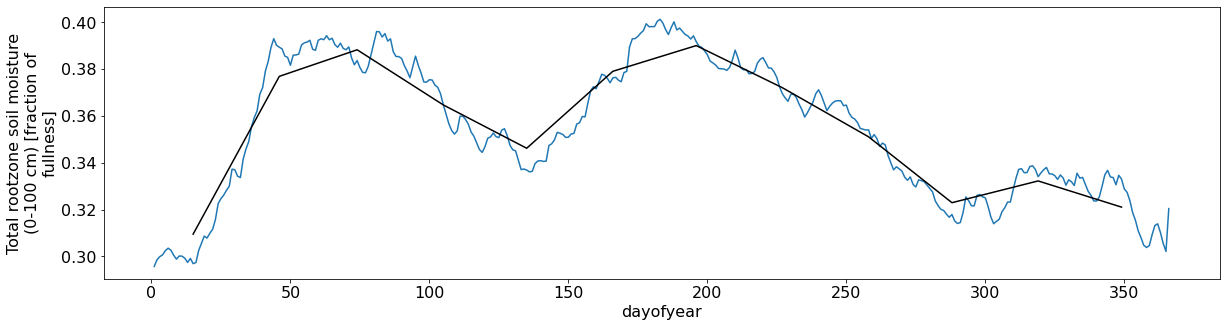

In [29]:
da_sm_daily_clim.plot(size = 5, aspect = 4)
da_sm_mon_clim.plot(color = 'k')

In [51]:
import scipy.stats

da_sm_mon_anom = da_sm_mon.groupby('time.month') - da_sm_mon.groupby('time.month').mean()

mon = list(range(1, 13))
corr_lag1 = []
for imon in mon:
    da1 = da_sm_mon_anom.isel(time = da_sm_mon_anom.time.dt.month.isin(imon))
    if imon==12:
        mon2 = 1
        corr = da_sm_mon_anom.isel(time = da_sm_mon_anom.time.dt.month.isin(mon2))
        corr = scipy.stats.pearsonr(da1.values[0:(len(da1)-1)], da2.values[1:len(da1)])[0]
    else:
        mon2 = imon+1
        da2 = da_sm_mon_anom.isel(time = da_sm_mon_anom.time.dt.month.isin(mon2))
        corr = scipy.stats.pearsonr(da1.values, da2.values)[0]
    corr_lag1.append(corr)

In [52]:
corr_lag1

[0.42379461117588096,
 0.6281432535338732,
 0.6565032462994693,
 0.7852809227435688,
 0.7339068859827586,
 0.7904911033433775,
 0.7293288264352419,
 0.8864323661320688,
 0.7456935655662006,
 0.758841906835229,
 0.6907465492238324,
 -0.10679375799875264]

In [37]:
da_sm_mon.isel(time = da_sm_mon.time.dt.month.isin(imon))

<xarray.DataArray 'sm_pct_regavg' (time: 52)>
array([0.40061597, 0.43941463, 0.60099161, 0.20141308, 0.49326439,
       0.2317703 , 0.42366822, 0.22952524, 0.33811929, 0.28571555,
       0.24128512, 0.13811388, 0.43329086, 0.13173166, 0.51156915,
       0.30945387, 0.37687829, 0.32200967, 0.38908994, 0.49557953,
       0.33184082, 0.1958301 , 0.46162624, 0.40017328, 0.15035188,
       0.31773086, 0.48217944, 0.31816842, 0.26474355, 0.26140647,
       0.37702136, 0.23304998, 0.15147543, 0.09893511, 0.26023986,
       0.25207053, 0.42582017, 0.13354016, 0.40799967, 0.27690739,
       0.27701944, 0.45099904, 0.31933004, 0.17509781, 0.11480338,
       0.4522317 , 0.36453913, 0.22321463, 0.14704457, 0.26813006,
       0.06885234, 0.43868073])
Coordinates:
  * time     (time) datetime64[ns] 1970-01-31 1971-01-31 ... 2021-01-31
Attributes:
    name:           sm_pct
    units:          fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

### Extra: Using DMI vs. SM axes for predictor influences

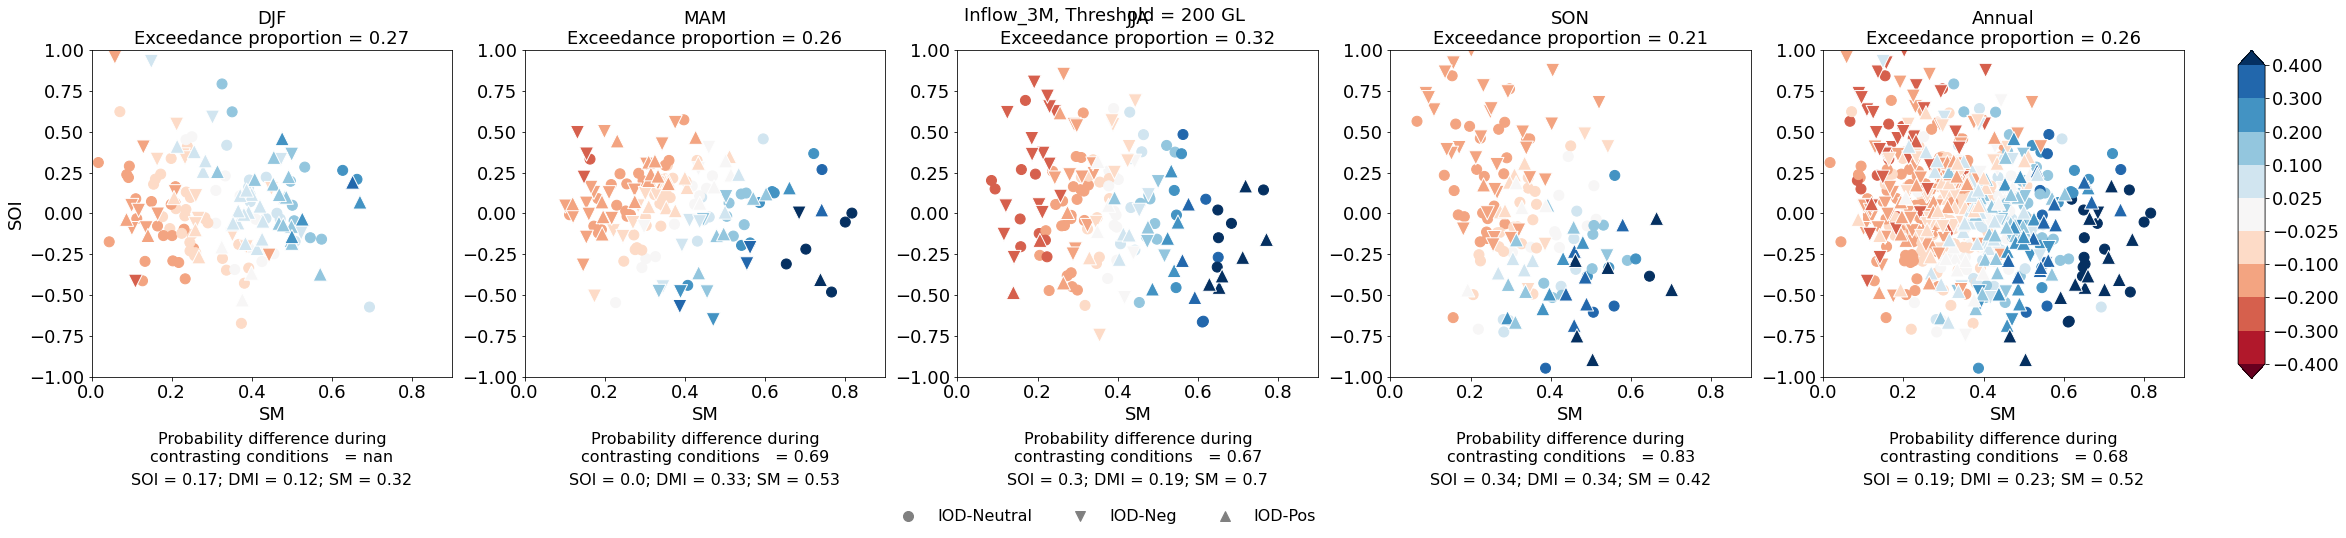

In [65]:
import matplotlib as mpl
from matplotlib.lines import Line2D

cmap = plt.cm.RdBu

bounds1 = [-0.4, -0.3, -0.2, -0.1, -0.025, 0.025, 0.1, 0.2, 0.3, 0.4]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap.N, extend='both')

bounds2 = [-0.3, -0.2, -0.1, -0.025, 0.025, 0.1, 0.2, 0.3]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap.N, extend='both')

# list of colorbar for each threshold
bounds_list = [bounds1, bounds2, bounds2, bounds2, bounds2]
norm_list = [norm1, norm2, norm2, norm2, norm2]

# settings for different IOD states
clim_state_list = ['Neutral', 'Neg', 'Pos']
marker_list = ['o', 'v', '^']
#edgecol_list = ['face', 'red', 'cyan']
edgecol_list = ['face', 'white', 'white']
size_list = [100, 200, 200]

dmi_axis_lim = (-1, 1)
sm_axis_lim = (0, 0.9)

thresh_list = np.unique(fitted_contrib_values_lov['Inflow_3M']['seas_thresh_info']['threshold'].values)
thresh_list = [thresh_list[1]]

seas_list = ['DJF', 'MAM', 'JJA', 'SON', 'Annual']

#******* should I change this? (maybe by season)
# sm_high = 0.7
# sm_low = 0.3
sm_high_dict = dict(zip(seas_list, perc90_list))
sm_low_dict = dict(zip(seas_list, perc10_list))

def add_scatter_plot(df_plot, norm, title, ax):
    for i, clim_state in zip(range(3), clim_state_list):
        cs = ax.scatter(df_plot['SM'][df_plot['ENSO state'] == clim_state], df_plot['DMI'][df_plot['ENSO state'] == clim_state], 
                               s = size_list[i], marker = marker_list[i], edgecolors = edgecol_list[i],
                               c = df_plot['probability'][df_plot['ENSO state'] == clim_state],#.map(colors),
                               cmap = cmap, norm = norm_list[it])
    ax.set_title(title)
    return cs
        
def calc_extreme_pred_diff(df_plot, sm_high, sm_low):
    # the mean differences between opposite quadrants
    df_high = df_plot[(df_plot['SM']>=sm_high) & (df_plot['SOI']>=8) & (df_plot['DMI']<=-0.4)]
    # df_high = df_plot[(df_plot['SM']>=sm_high) & (df_plot['SOI']>=8)]
    p_high_mean = df_high['probability'].mean()
    df_low = df_plot[(df_plot['SM']<=sm_low) & (df_plot['SOI']<=-8) & (df_plot['DMI']>=0.4)]
    # df_low = df_plot[(df_plot['SM']<=sm_low) & (df_plot['SOI']<=-8)]
    p_low_mean = df_low['probability'].mean()
    p_diff = p_high_mean - p_low_mean
    return p_diff

def calc_extreme_singlePred_diff(df_plot, predName, high, low):
    # the mean differences between opposite quadrants
    df_high = df_plot[(df_plot[predName]>=high)]
    p_high_mean = df_high['probability'].mean()
    df_low = df_plot[(df_plot[predName]<=low)]
    p_low_mean = df_low['probability'].mean()
    p_diff = abs(p_high_mean - p_low_mean)
    return p_diff

for inflow_var in ['Inflow_3M']: #, 'Inflow_6M']:
    fitted_prob_all = np.array(fitted_contrib_values_lov[inflow_var]['fittedValues'])
    for it, thresh in zip(range(len(thresh_list)), thresh_list):
        fig, ax = plt.subplots(nrows=1,ncols=5,figsize=(7.5*5,6))  #width, height
        #ax = ax.flatten() 
        count = 0
        for seas_sel in seas_list:
            sm_high = sm_high_dict[seas_sel]
            sm_low = sm_low_dict[seas_sel]
            if seas_sel == 'Annual':
                # indices of the model runs for the threshold
                ind_array = np.where(fitted_contrib_values_lov[inflow_var]['seas_thresh_info']['threshold'].values == thresh)[0]

                # calculating the observed proportion
                num_total = len(df_input[inflow_var])   #total number of obs in the season
                num_exceed = len(np.where(df_input[inflow_var] >= thresh)[0])  #the number of obs that exceeded thersh
                obs_prop = num_exceed/num_total

                # getting the fitted probability for that season & threshold
                fitted_prob_seas_thresh = fitted_prob_all[ind_array]
                dict_temp = {'SOI': df_input['SOI'],
                 'DMI': df_input['DMI'],
                 'SM': df_input['SM'],
                 'probability': fitted_prob_seas_thresh-obs_prop}
                df_plot = pd.DataFrame(dict_temp)
            else:
                # indices of the model runs for the threshold & season
                ind_array1 = np.where(fitted_contrib_values_lov[inflow_var]['seas_thresh_info']['threshold'].values == thresh)[0]
                ind_array2 = np.where(fitted_contrib_values_lov[inflow_var]['seas_thresh_info']['season'].values == seas_sel)[0]
                ind_array = np.intersect1d(ind_array1, ind_array2)

                # calculating the observed proportion estimate for that season & threshold
                num_total = len(df_input[df_input['season']==seas_sel][inflow_var])   #total number of obs in the season
                num_exceed = len(np.where(df_input[df_input['season']==seas_sel][inflow_var] >= thresh)[0])  #the number of obs that exceeded thersh
                obs_prop = num_exceed/num_total

                # getting the fitted probability for that season & threshold
                fitted_prob_seas_thresh = fitted_prob_all[ind_array]
                dict_temp = {'SOI': df_input[df_input['season']==seas_sel]['SOI'],
                 'DMI': df_input[df_input['season']==seas_sel]['DMI'],
                 'SM': df_input[df_input['season']==seas_sel]['SM'],
                 'probability': fitted_prob_seas_thresh-obs_prop}
                df_plot = pd.DataFrame(dict_temp)

            iod_state = np.repeat('Neutral', len(df_plot))
            iod_state[np.where(df_plot['DMI'].values >= 0.4)] = 'Pos'
            iod_state[np.where(df_plot['DMI'].values <= -0.4)] = 'Neg'
            df_plot['IOD state'] = iod_state
            
            enso_state = np.repeat('Neutral', len(df_plot))
            enso_state[np.where(df_plot['SOI'].values >= 8)] = 'Pos'
            enso_state[np.where(df_plot['SOI'].values <= -8)] = 'Neg'
            df_plot['ENSO state'] = enso_state
            
            title = seas_sel + '\nExceedance proportion = ' + str(np.round(obs_prop, 2))
            cs = add_scatter_plot(df_plot, norm = norm_list[it], title = title, ax = ax[count])
            
            # ax[count].text(0.06, 0.9, 'Exceedance\nProportion = ' + str(np.round(obs_prop, 2)), 
            #                ha='left', va='center', transform=ax[count].transAxes, fontsize=14, fontstyle='italic', color = 'black')
            
            p_diff = calc_extreme_pred_diff(df_plot, sm_high, sm_low)
            soi_diff = calc_extreme_singlePred_diff(df_plot, 'SOI', 8, -8)
            dmi_diff = calc_extreme_singlePred_diff(df_plot, 'DMI', 0.4, -0.4)
            sm_diff = calc_extreme_singlePred_diff(df_plot, 'SM', sm_high, sm_low)
            
            # if p_diff > 0.3:
            #     fontweight='bold'
            # else:
            #     fontweight='normal'
            fontweight = 'normal'
            ax[count].text(0.5, -0.22, 'Probability difference during\ncontrasting conditions   = ' + str(np.round(p_diff, 2)), 
                           ha='center', va='center', transform=ax[count].transAxes, fontweight=fontweight, fontsize=16, color = 'black')
            ax[count].text(0.5, -0.32, 'SOI = ' + str(np.round(soi_diff, 2)) + '; DMI = ' + str(np.round(dmi_diff, 2)) + '; SM = ' + str(np.round(sm_diff, 2)), 
                           ha='center', va='center', transform=ax[count].transAxes, fontweight=fontweight, fontsize=16, color = 'black')
            
            if count == 0:
                ax[count].set_ylabel('SOI')
            ax[count].set_xlabel('SM')
            ax[count].set_xlim(sm_axis_lim)
            ax[count].set_ylim(dmi_axis_lim)
            count=count+1
            
        cbar_ax = fig.add_axes([0.92, 0.12, 0.01, 0.76])
        fig.colorbar(cs, cax=cbar_ax)
        legend_elements = []
        for i, iod_state in zip(range(3), iod_state_list):
                legend_elements.append(Line2D([0], [0], linewidth=0, marker=marker_list[i], color='grey', label='IOD-' + iod_state, markerfacecolor='grey', markersize=10))
                
        fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False)
        plt.suptitle(inflow_var + ', Threshold = ' + str(round(thresh/1000)) + ' GL')
    
        fig.savefig(out_dir + inflow_var + 'thresh_' + str(thresh) + '_probability_diff_from_random.png', bbox_inches='tight', dpi = 600)
        fig.savefig(out_dir + inflow_var + 'thresh_' + str(thresh) + '_probability_diff_from_random.pdf', bbox_inches='tight', format = 'pdf')